## Cleaning FERC 1 Fuel data
This notebook is meant to help get you understand the data cleaning process for FERC Form 1 fuel data for heat content and price per MMBTU data.

In [5]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
pudl_engine = pudl.db_connect_pudl()

## Define a function to clean data frames:
## What kind of errors are we fixing? Why is this kind of function a reasonable thing to do?
Looking at some of the distributions of the data below, it becomes clear immediately that there are the data was originally entered in a variety of ways. 

Data has been entered in the different units, for example coal heat content values are entered in mmbtu per pound for some records while for most records it is entered in mmbtu per ton. Similarly we see data entered in different orders of magnitude, like gas heat content values entered in mmbtu per cubic foot rather than in mmbtu per thousand cubic foot.

Since these data entry differences are separate by two or more orders of magnitude, we can often clearly delineate between populations. We can identify the main population of values by looking at known facts about the data in question. For example, the average heat content of a ton of coal is roughly 20 mmbtu. We can then identify the end points of the range of reasonable values by looking at the end points of the main population.

Since data outside of the main population is in most cases easily distinguishable and off by a  given factor (e.g. 2000 for heat content per pound rather than per ton) we can with reasonable confidence use a small set of multipliers to bring outlying data into the main population and correct for errors in how the data was entered.

In [38]:
# First, let's pull in the applicable data from the PUDL FERC tables:
fuel_df = pd.read_sql('''SELECT * from fuel_ferc1''',pudl_engine)
coal = fuel_df[fuel_df.fuel=='coal']
gas = fuel_df[fuel_df.fuel=='gas']

Then, we'll define a function that takes as arguments: 

- a data series to be cleaned
- minimum and maximum values bounding the reasonable range of values for the series
- multipliers (a list) to the minimum and maximum values are divided to define additional ranges of data, which are brought into the reasonable range by multiplying the values in the additional ranges by the multipliers (e.g. if a set of values is 1000 times too large to fit in the reasonable range, its multiplier will be .001).

The function will return a cleaned series.

In [33]:
def fixit(tofix, min, max, mults):
    
    fixed = tofix.copy()
    fixed = fixed[fixed > 0]
    for mult in mults:
        fixed = fixed.apply(lambda x: x*mult if x > min/mult and x < max/mult else x)
    fixed = fixed.apply(lambda x: np.nan if x < min or x > max else x)
    return(fixed)

We'll next define a function to show us graphs of what the data looks like before and after it is cleaned, and to show us how much data the cleaning process was not able to clean. This function will take 5 arguments:

- a series of data to be cleaned
- a series of data which has been cleaned by the cleaning function
- the title (string) to apply to the before and after graphs
- the x label (string) to apply to the before and after graphs
- the y label (string) to apply to the before and after graphs

The function will returned the before and after graphs and the percentage of how many values were not cleaned and were instead set to NaN.

Our showfix function first displays unaltered populations on a log-log scale for two reasons. These populations are separated by orders of magnitude and it would be difficult to show them on the same graph otherwise. These populations are also often vastly different sizes: when one population is has thousands of occurences and the other tens, one is not able to see both without a logarthmic scale.

The showfix function then displays the data once multipliers have been applied to the populations. This population necessarily lies in the same order of magnitude so a linear x axis scale makes sense for view. It's more intuitive for most to view the frequency of occurences on a linear scale as well so a linear y axis is used as well. 

In [34]:
def showfix(tofix,fixed,title,xlabel,ylabel):
    
    min_1 = tofix[tofix > 0].min()
    max_1 = tofix.max()
    fraction_lost =  ( fixed.isnull().sum() / len(fixed) ) * 100
    show_fraction = 'The percentage of values set to NaN is {} %'\
    .format(round(fraction_lost,2))
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }
    
    fig_1 = plt.figure(figsize=(16,12))
    plt.subplot(2,1,1)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    ax = fig_1.axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xlim(min_1,max_1)
    plt.hist(tofix, bins=np.logspace(np.log10(min_1), np.log10(max_1), 100))
    
    plt.subplot(2,1,2)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    plt.hist(fixed.dropna(),bins=100)
    plt.text(0, .05, show_fraction, transform=fig_1.transFigure,fontdict=font)
    plt.show()

## FERC Form 1 Average heat content
### Average heat content of coal
Let's use these two functions to clean the average heat content of Form 1 coal and gas data, respectively. The average heat content of a ton of coal consumed in the United States is 19.48 mmbtu (according the EIA's 2015 data: https://www.eia.gov/tools/faqs/faq.php?id=72&t=2). 

Looking at the primary distribution around 20 mmbtu, we see that population of data begins just after 10 mmbtu and ends before 30 mmbtu. This lines up fairly well with the commonly accept energy content values for lignite coal, 9 - 17 mmbtu per short ton (https://en.wikipedia.org/wiki/Lignite), and bituminous coal, 21 - 30 mmbtu per short ton (https://en.wikipedia.org/wiki/Bituminous_coal). The range for coal is 10 to 29 mmbtu per ton.

We'll use 10 and 29 as the lower and upper boundary of acceptable data as we search for and apply multipliers to outlying populations. We'll define a simple graphing function to help us make the graph and a flexible graphing function to help us make slightly more complex graphs later on.

In [35]:
def simplegraph(series,xlabel,ylabel,title,range1,range2):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.hist(series,bins=100,range=(range1,range2))
    plt.show()

In [36]:
def flexiblegraph(series,xlabel,ylabel,title,yscale,range1,range2,bins):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.yscale(yscale)
    plt.hist(series,bins=bins,range=(range1,range2))
    plt.show()

Here's the primary distribution of coal heat content values:

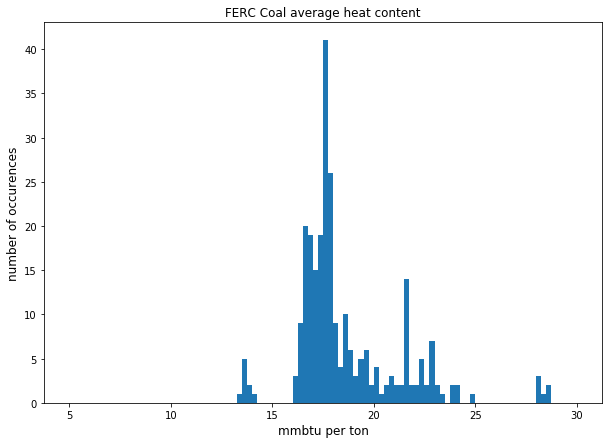

In [39]:
simplegraph(coal.fuel_avg_mmbtu_per_unit,'mmbtu per ton','number of occurences',\
           'FERC Coal average heat content',5,30)

There are two outlying populations: 
- one population around .01, which is off by a factor of 2000, as heat content is reported in mmbtu per pound rather than per ton
- one population around 2.0e-5, which is off by a factor of 1e6, as heat content is reported in btu per ton rather than mmbtu per ton.

We will apply the cleaning function and the showfix function to see how the data looks once the multipliers are applied:

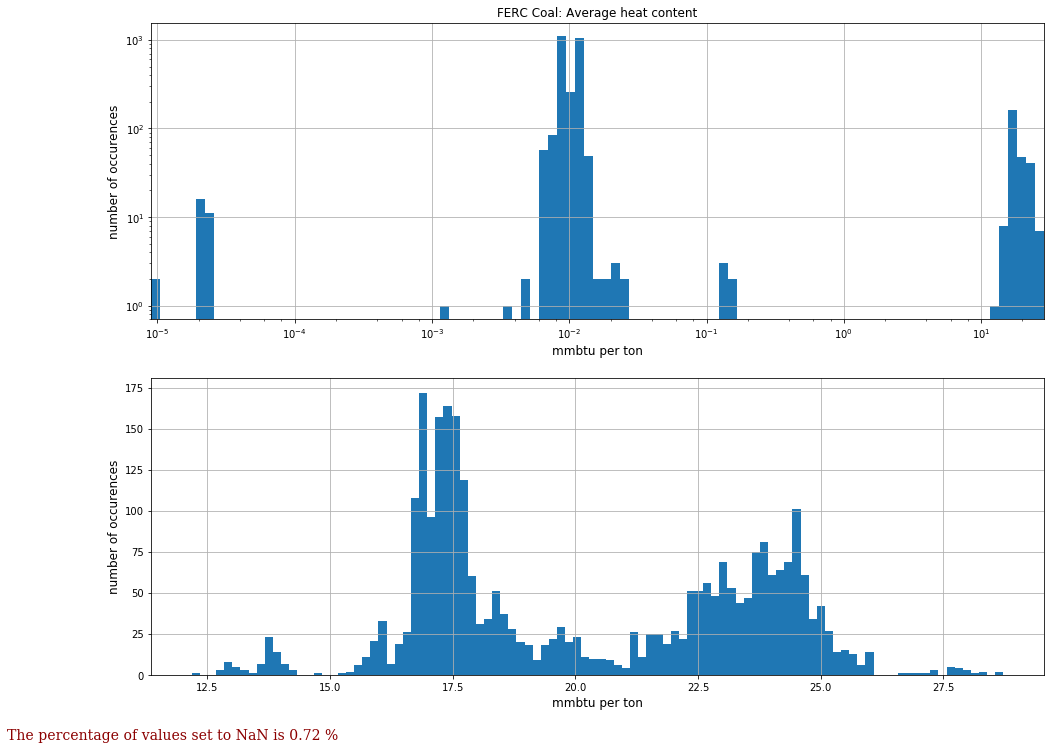

In [52]:
to_fix_avg_heat_content_coal = coal.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_coal = fixit(coal.fuel_avg_mmbtu_per_unit,10,29,[2000,1e6])

showfix(to_fix_avg_heat_content_coal,fixed_avg_heat_content_coal,'FERC Coal: Average heat content',\
        'mmbtu per ton','number of occurences')

There are two distinct humps within the cleaned dataset, one around 17 mmbtu per ton, corresponding to tons of lignite coal, and another around 24 mmbut per ton, corresponding to bituminous coal. 

### Average heat content of natural gas

As we turn our attention to natural gas, one expects to find the main population near 1 mmbtu per mcf (per EIA 2016 data https://www.eia.gov/dnav/ng/ng_cons_heat_a_epg0_vgth_btucf_a.htm). Looking at the data near 1, one finds the main population begins after .8 and ends before 1.25 mmbtu per mcf.

Natural gas heat contents are typically .95 mmbtu per mcf or greater (according to the EPA gross heat content values https://www3.epa.gov/ttnchie1/ap42/ch01/final/c01s04.pdf). Looking at the heat content delivered to consumers (the only EIA data I could find, https://www.eia.gov/dnav/ng/ng_cons_heat_a_EPG0_VGTH_btucf_m.htm) one sees that gas heat content is typically above ~.95 mmbtu per mcf as well. The EIA writes that "Heat content of combustible energy forms can be expressed in terms of either gross heat content (higher or upper heating value) or net heat content (lower heating value), depending upon whether or not the available heat energy includes or excludes the energy used to vaporize water (contained in the original energy form or created during the combustion process). The Energy Information Administration typically uses gross heat content values." 

The EIA Form 923 instructions (https://www.eia.gov/survey/form/eia_923/instructions.pdf ask for heat content in gross heat content and include heating value ranges. The range for natural gas is .8 to 1.2 mmbtu per mcf - we'll use these values.

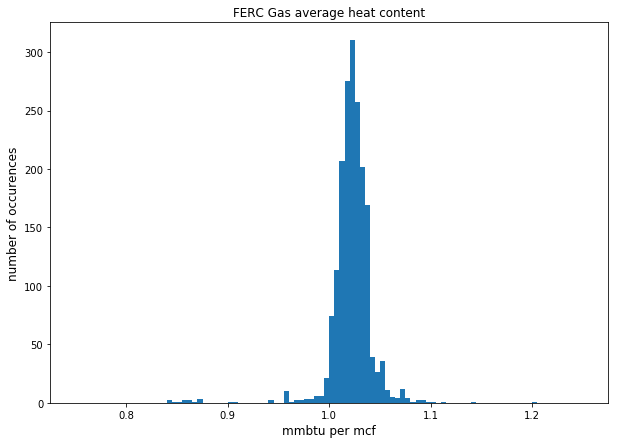

In [44]:
simplegraph(gas.fuel_avg_mmbtu_per_unit,'mmbtu per mcf','number of occurences',\
           'FERC Gas average heat content',.75,1.25)

There are two outlying populations: 
- one population around 1e-3, which is off by a factor of 1000, as heat content is reported in mmbtu per cubic foot rather than mmbtu per thousand cubic foot
- one population around 1e-6, which is off by a factor of 1e6, as heat content is reported in btu per mcf rather than mmbtu per mcf.

Let's again apply the cleaning function and the showfix function and take a look at the cleaned, combined distribution.

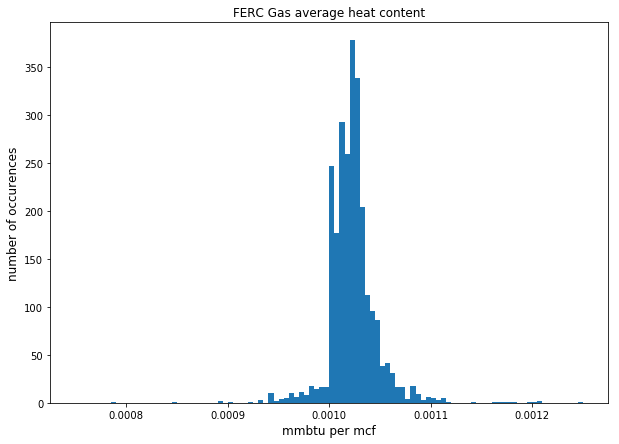

In [140]:
simplegraph(gas.fuel_avg_mmbtu_per_unit,'mmbtu per mcf','number of occurences',\
           'FERC Gas average heat content',.00075,.00125)

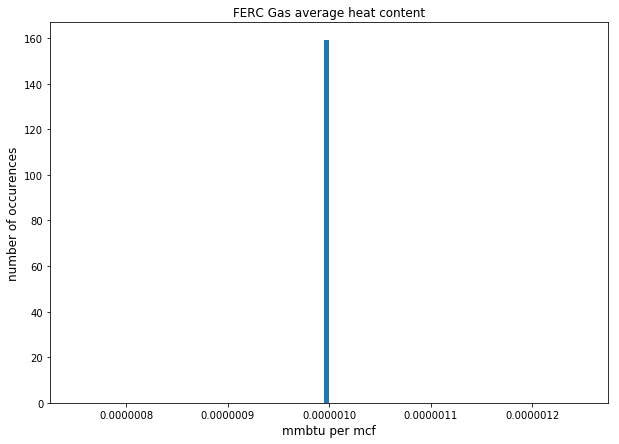

In [141]:
simplegraph(gas.fuel_avg_mmbtu_per_unit,'mmbtu per mcf','number of occurences',\
           'FERC Gas average heat content',.00000075,.00000125)

A small number of utilities reporting in btu per mcf rounded to .000001, creating a spike of ~150 values.

In [142]:
gas[(gas.fuel_avg_mmbtu_per_unit > 0) & (gas.fuel_avg_mmbtu_per_unit < .0000012)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
428,429,27,Dicks Creek Gt,2007,gas,mcf,4534.0,0.000001,9.602,0.000,9.340,27.0,0.0000
435,436,27,Fayette,2007,gas,mcf,4609161.0,0.000001,9.547,9.547,9.290,70.0,7.5070
436,437,27,Lee,2007,gas,mcf,563661.0,0.000001,8.829,8.829,8.590,110.0,12.2830
437,438,27,Washington,2007,gas,mcf,4900937.0,0.000001,9.450,9.450,9.190,70.0,7.4400
438,439,27,Vermillion,2007,gas,mcf,1591965.0,0.000001,5.534,5.534,5.380,70.0,13.4200
439,440,27,Hanging Rock,2007,gas,mcf,11971713.0,0.000001,9.832,9.832,9.560,70.0,7.5640
444,445,178,Woodsdale Gt,2007,gas,mcf,1780794.0,0.000001,8.002,8.002,7.784,235.0,30.3080
606,607,99,Eaton,2007,gas,mcf,301939.0,0.000001,7.665,0.000,7.515,113.0,15.0550
609,610,99,Watson,2007,gas,mcf,533399.0,0.000001,8.777,0.000,8.423,212.0,0.0000
610,611,99,Watson Ct,2007,gas,mcf,18435.0,0.000001,8.749,0.000,8.396,147.0,17.5430


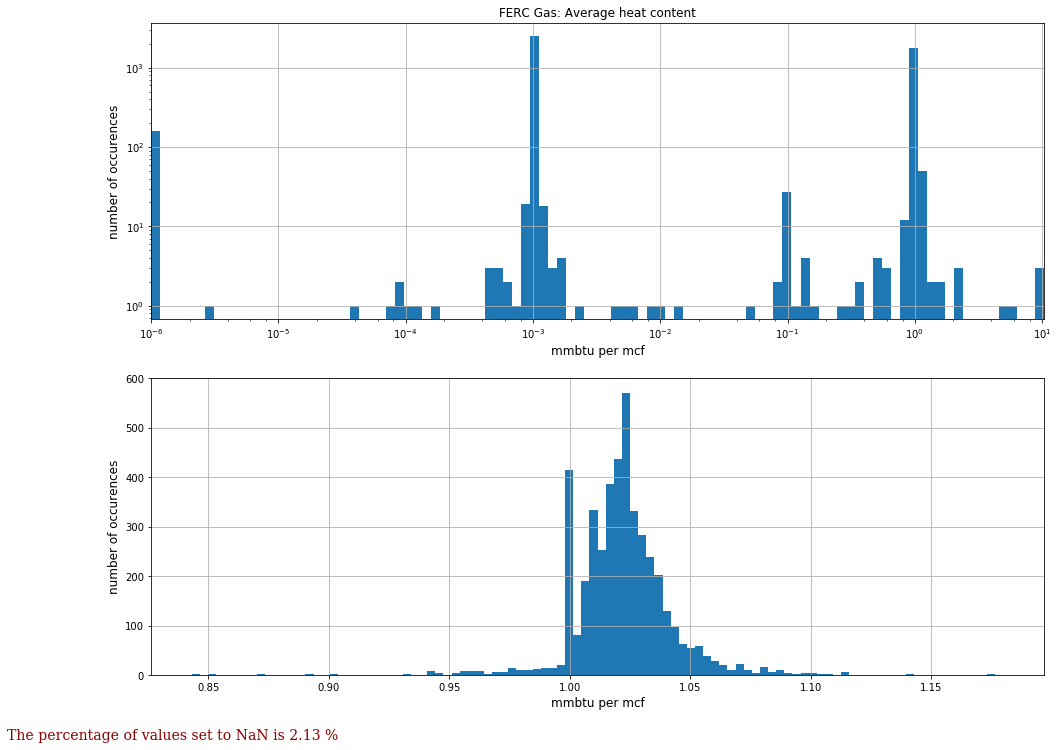

In [138]:
to_fix_avg_heat_content_gas = gas.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_gas = fixit(gas.fuel_avg_mmbtu_per_unit,.8,1.2,[1000,1e6])

showfix(to_fix_avg_heat_content_gas,fixed_avg_heat_content_gas,'FERC Gas: Average heat content',\
        'mmbtu per mcf','number of occurences')

The heat content per mcf, aside from the spike of rounded values (it appears many utilities round to 1) around 1.0 mmbtu per mcf, appears as we would expect it to appear given an average US natural gas heat content of just above one. We should note that some utilities entered mmbtu as their fuel units but there doesn't appear to alter their heat content values in a discernable way:

In [139]:
gas.fuel_unit.value_counts()

mcf      4563
mmbtu      75
bbl        18
gal        10
ton         1
Name: fuel_unit, dtype: int64

In [144]:
gas[gas.fuel_unit == 'mmbtu']

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
120,121,122,Huron Gt,2007,gas,mmbtu,33037.0,0.136500,7.028,7.028,23.218,219.0,0.031167
122,123,122,Yankton,2007,gas,mmbtu,7717.0,0.001000,8.136,8.136,10.864,236.0,7.575909
124,125,122,Huron Ct,2007,gas,mmbtu,62152.0,0.136500,7.362,7.362,45.755,92.0,0.012564
1046,1047,132,Solway,2007,gas,mmbtu,641808.0,0.638592,7.060,7.060,7.055,85.0,11.951000
1427,1428,122,Huron Gt,2008,gas,mmbtu,3386.0,0.001000,10490.000,10490.000,3.552,-296.0,-0.028217
1429,1430,122,Yankton,2008,gas,mmbtu,3062.0,0.001000,9.407,9.407,9.274,362.0,14.439371
1431,1432,122,Huron Ct,2008,gas,mmbtu,82230.0,0.001000,8.390,8.390,68.981,142.0,0.016923
1624,1625,132,Solway,2008,gas,mmbtu,546755.0,0.545600,8.290,8.290,8.290,97.0,11.652000
1656,1657,294,Wabash River Unit #1,2008,gas,mmbtu,9358849.0,0.000000,6.070,6.070,6.070,54.0,8.856000
1657,1658,294,Wabash River Unit #1,2008,gas,mmbtu,548000.0,0.000000,9.120,9.120,9.120,81.0,0.000000


## FERC Form 1 Cost per mmbtu
Let's use these two functions to clean the cost per mmbtu of Form 1 coal and gas data, respectively.

One would expect to find the main distribution of coal cost per mmbtu around $2 per mmbtu (per EIA monthly data https://www.eia.gov/electricity/monthly/epm_table_grapher.cfm?t=epmt_4_10_a and annual data https://www.eia.gov/electricity/annual/html/epa_07_04.html). Zooming in on this population, one sees that most of the values lie between .5 and 6 dollars per mmbtu.

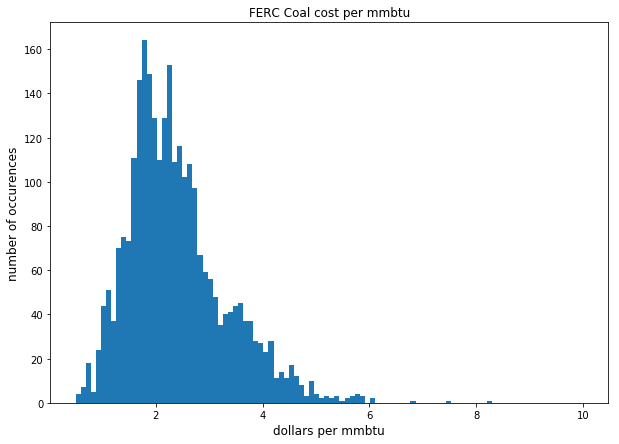

In [49]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', .5,10)

We can compare these results to EIA 923 data. We'll start by pulling the fuel receipts and costs data. When weighted by the amount of fuel delivered we see that most values lie between .5 and 7 dollars. We'll use these values to define the bounds of the main population of FERC data.

In [ ]:
fuel_rc = pd.read_sql('''SELECT fuel_quantity,energy_source, fuel_group, average_heat_content, fuel_cost, plant_id, report_date \
FROM fuel_receipts_costs_eia923''', con = pudl_engine)

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


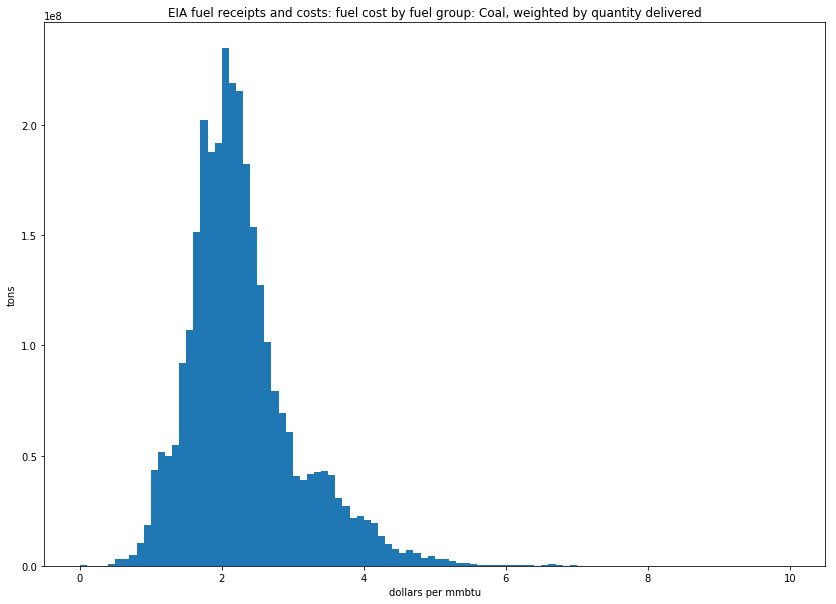

In [110]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_coal.fuel_cost,range=(0,10),weights=eia_rc_coal.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Coal, weighted by quantity delivered')
plt.ylabel('tons')
plt.xlabel('dollars per mmbtu')

The population begins around .5.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


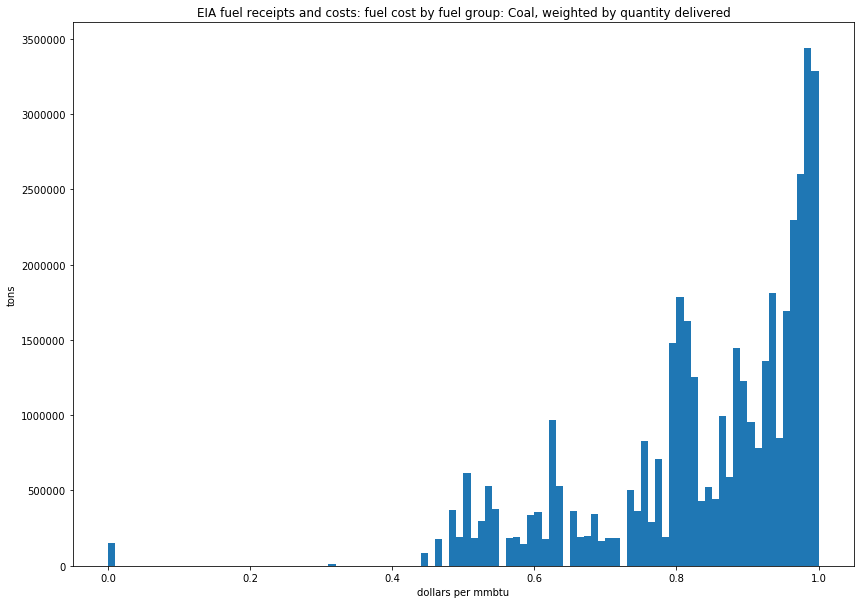

In [111]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_coal.fuel_cost,range=(0,1),weights=eia_rc_coal.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Coal, weighted by quantity delivered')
plt.ylabel('tons')
plt.xlabel('dollars per mmbtu')

The population ends around 7.5.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


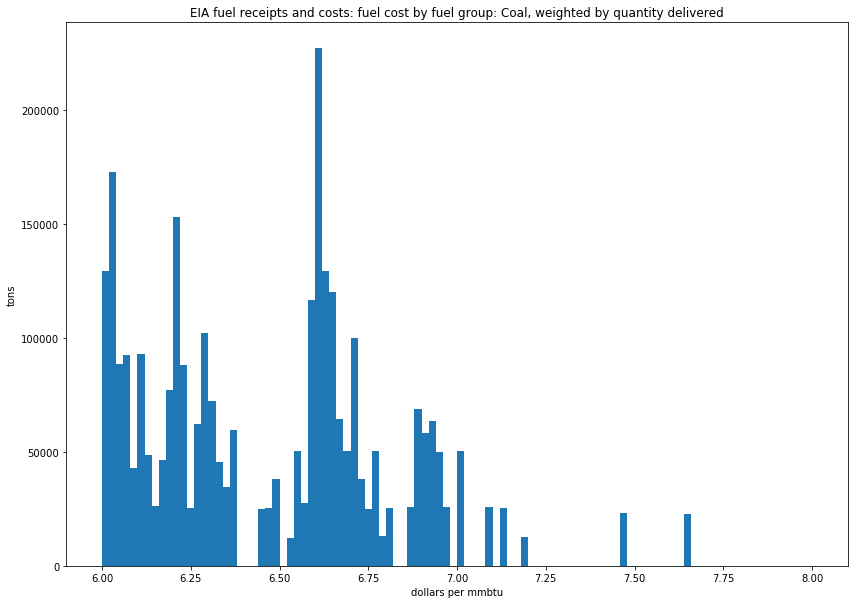

In [112]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_coal.fuel_cost,range=(6,8),weights=eia_rc_coal.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Coal, weighted by quantity delivered')
plt.ylabel('tons')
plt.xlabel('dollars per mmbtu')

Returning our attention to the FERC data, there are two outlying populations: 
- one population around .002, which values are all associated with one utility, respondent_id 130.
- one population around 200, which is off by a factor of 100, as the utility reported cost in cents per mmbtu, rather than dollars per mmbtu.

Let's take a look at the population around .001. All of these values appear to be attributable to `respondent_id` 130.

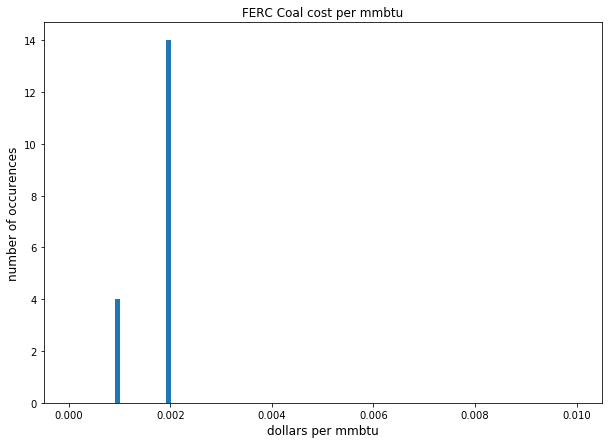

In [36]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', .00001,.01)

In [145]:
coal[(coal.fuel_cost_per_mmbtu > 0) & (coal.fuel_cost_per_mmbtu < .004)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
1055,1056,130,Sooner,2007,coal,ton,3780090.0,0.017590,19.708,0.0,0.001,11.0,10.238
1058,1059,130,Muskogee,2007,coal,ton,4998369.0,0.017577,20.719,0.0,0.001,12.0,10.495
1602,1603,130,Sooner,2008,coal,ton,4510024.0,17.584000,19.349,0.0,0.001,11.0,10.299
1605,1606,130,Muskogee,2008,coal,ton,5836557.0,17.582000,20.920,0.0,0.001,18.0,10.459
2869,2870,130,Sooner,2009,coal,ton,3877888.0,17.605000,30.904,0.0,0.002,18.0,10.425
2872,2873,130,Muskogee,2009,coal,ton,5139685.0,17.630000,28.810,0.0,0.002,15.0,9.235
5032,5033,130,Sooner,2010,coal,ton,3471416.0,17.600000,33.949,0.0,0.002,20.0,10.197
5034,5035,130,Muskogee,2010,coal,ton,5046150.0,17.581000,31.196,0.0,0.002,190.0,10.939
6468,6469,130,Sooner,2011,coal,ton,4059847.0,17.601000,36.723,0.0,0.002,22.0,10.469
6470,6471,130,Muskogee,2011,coal,ton,5321781.0,17.640000,32.789,0.0,0.002,20.0,10.831


Let's take a look at the population around 200.

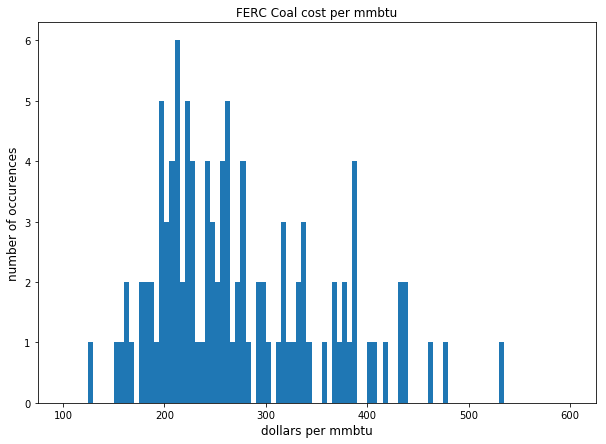

In [34]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', 100,600)

There is also a cluster of values around 2000 but it is unclear what is causing these values to be off by 1000.

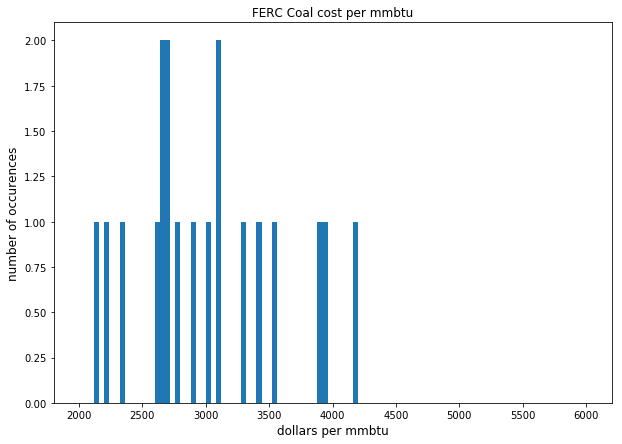

In [193]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', 2000,6000)

When we apply the two cleaning functions, we see a distribution with two peaks, which appears to correspond with the price premium subbituminous higher heat content coal versus lower heat content lignite coal.

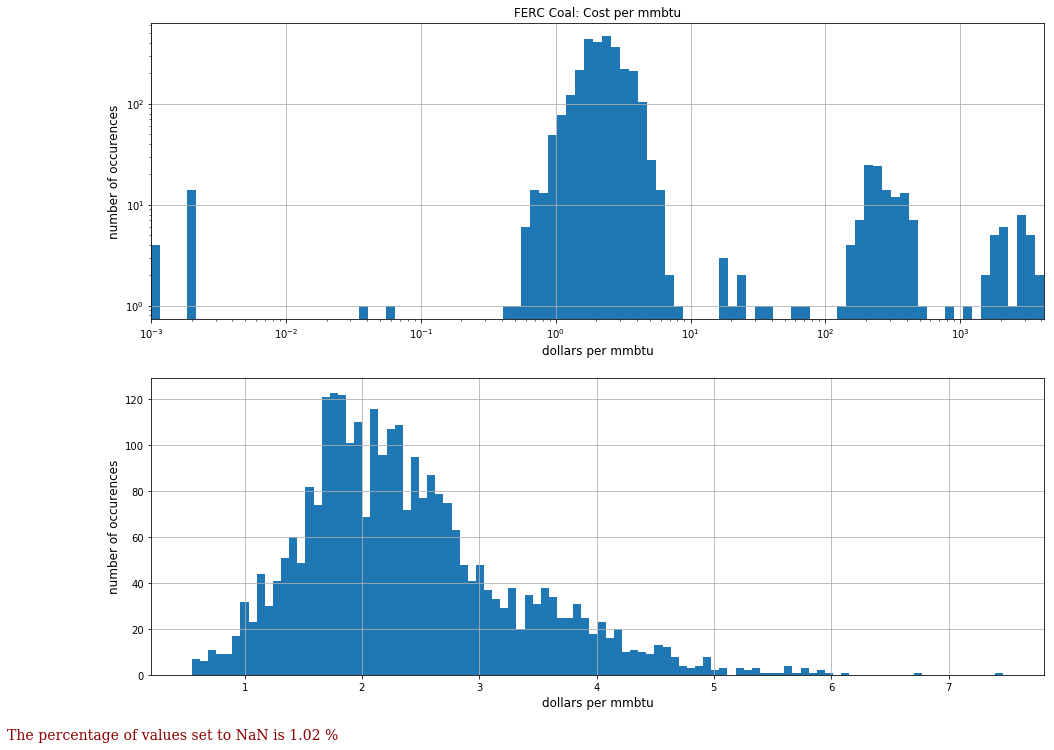

In [192]:
to_fix_cost_per_mmbtu_coal = coal.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_coal = fixit(coal.fuel_cost_per_mmbtu,.5,7.5,[.01,.001])

showfix(coal.fuel_cost_per_mmbtu,fixed_cost_per_mmbtu_coal,'FERC Coal: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

### Gas cost per mmbtu
As we turn our attention to natural gas, one expects to find the main population between roughly 2.5 and 15 dollars per mmbtu (per EIA Henry Hub data https://www.eia.gov/dnav/ng/hist/rngwhhdd.htm). One does see residential prices as high as nearly 40 dollars per mcf. Looking at the data near 5, one finds the main population begins after 2.5 and with a tail extending out to 40 dollars per mmbtu.

For natural gas pricing, EIA 923 instructions instruct respondents to "include the following pipeline charges: fuel losses, transportation reservation charges, balancing costs, and distribution system costs outside of the plant. Because these types of fees can skew the cost of the fuel per MMBtu, provide an explanation." Therefore, we're likely to see some values above 15 dollars per mmbtu, although we shouldn't see consistently high pricing like we see in the residential data.

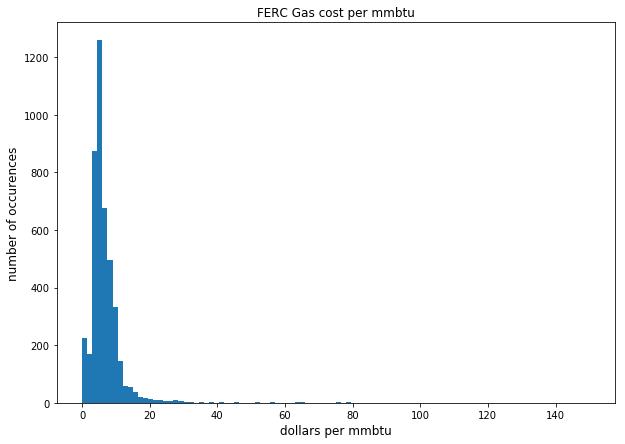

In [213]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 0,150)

When we look at EIA fuel cost data weighted by quantity delivered we see a clear drop off after 15 dollars per mcf and a tail of values going out to roughly 35.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


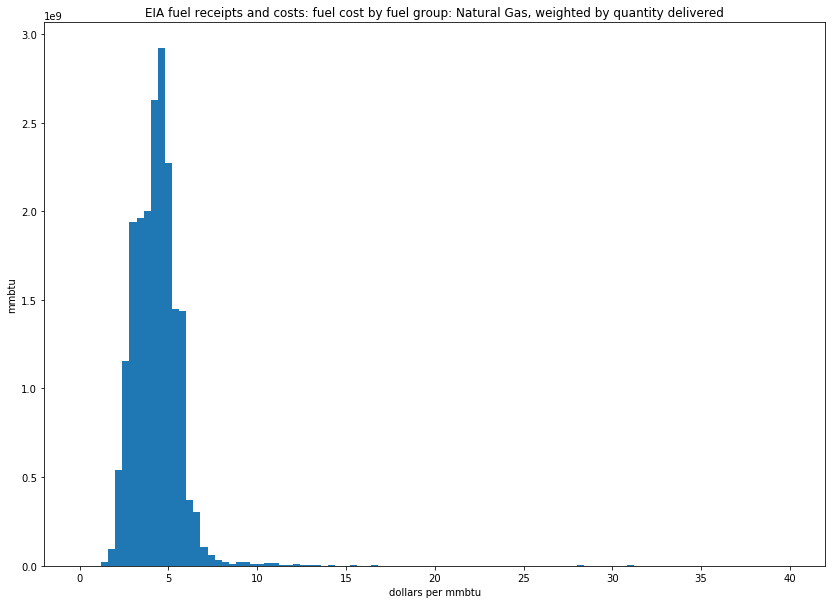

In [134]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_gas.fuel_cost,range=(0,40),weights=eia_rc_gas.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Natural Gas, weighted by quantity delivered')
plt.ylabel('mmbtu')
plt.xlabel('dollars per mmbtu')

This tail is more apparent when fuel costs are not weighted by quantity delivered.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


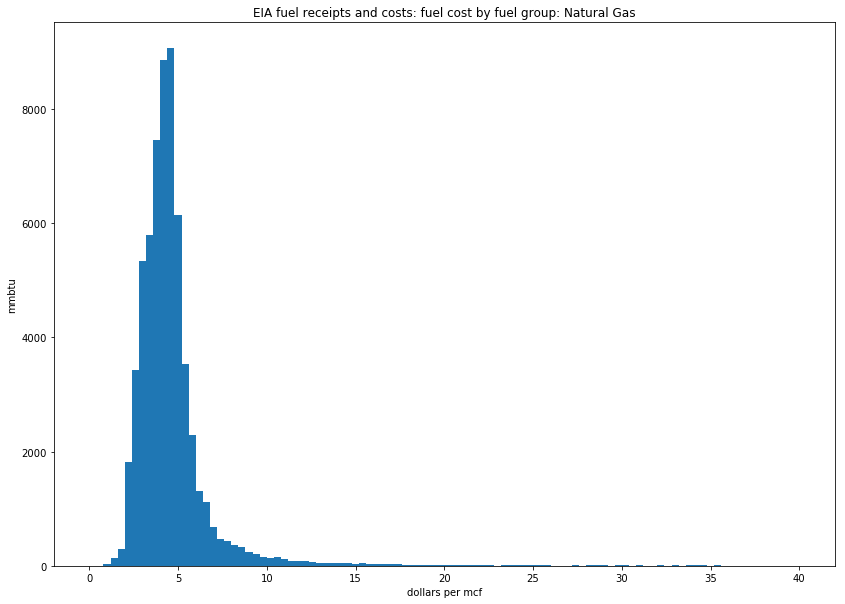

In [123]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_gas.fuel_cost,range=(0,40),bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Natural Gas')
plt.ylabel('mmbtu')
plt.xlabel('dollars per mcf')

The population appears to begin around 1 - it's difficult to say exactly where to draw the line.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


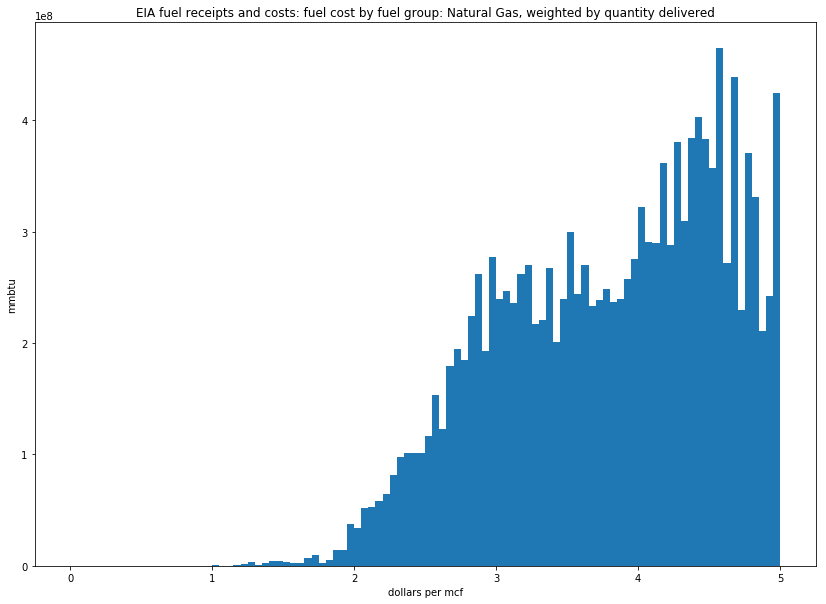

In [114]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_gas.fuel_cost,range=(0,5),weights=eia_rc_gas.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Natural Gas, weighted by quantity delivered')
plt.ylabel('mmbtu')
plt.xlabel('dollars per mcf')

Zooming in.

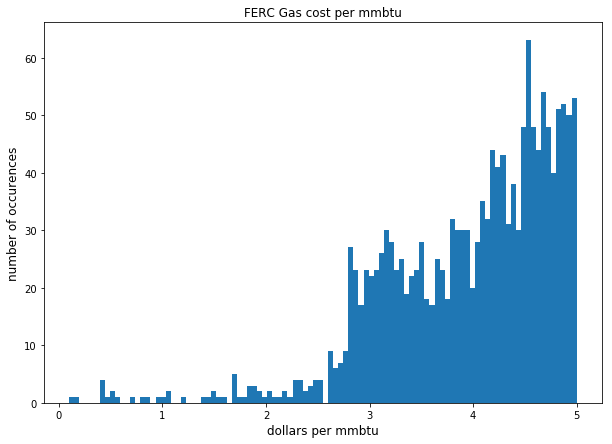

In [295]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', .1,5)

The distribution begins to drop off considerable after 12 dollars per mmbtu.

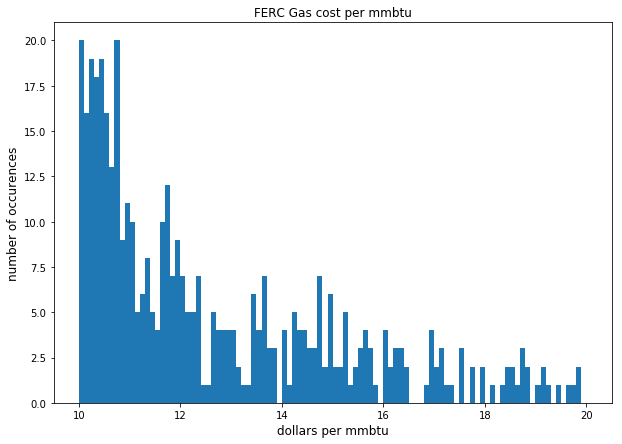

In [68]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 10,20)

The tail continues and drops off even further after roughly 50 dollars per mmbtu.

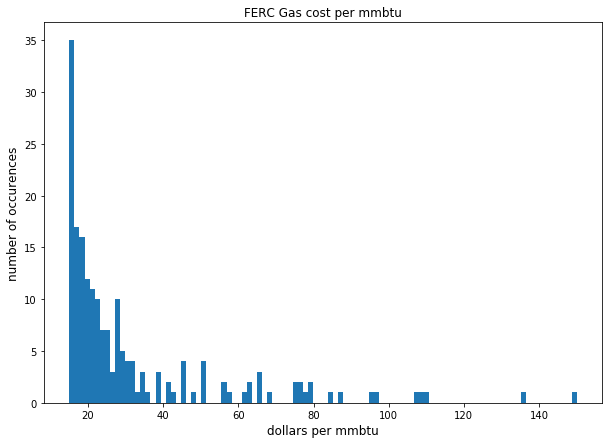

In [69]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 15,150)

When weighted by quantity burned, we see a much tighter distribution and values don't range past 35 dollars per mmbtu.

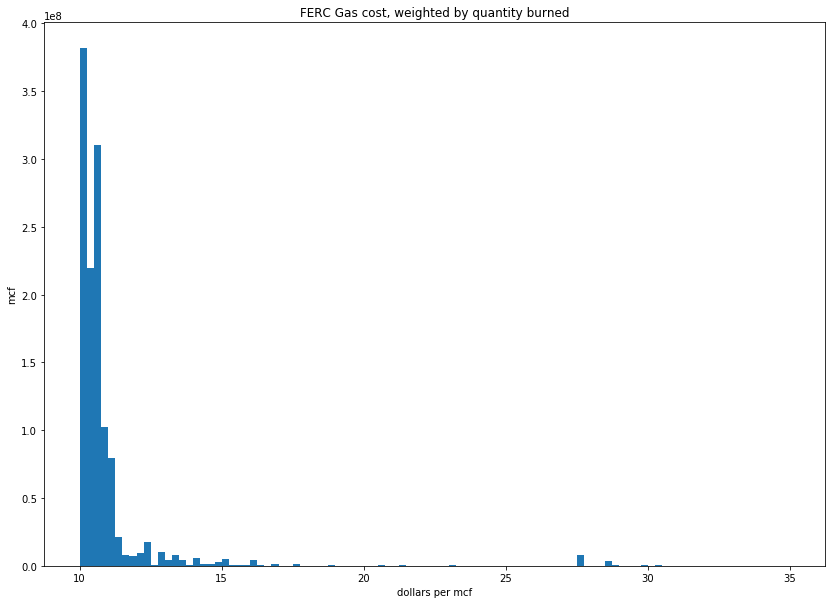

In [153]:
plt.figure(figsize=(14,10))
plt.hist(gas.fuel_cost_per_mmbtu,range=(10,35),weights=gas.fuel_qty_burned,bins=100)
plt.title('FERC Gas cost, weighted by quantity burned')
plt.ylabel('mcf')
plt.xlabel('dollars per mcf')

The second population stretches from just after 250 to 4000 - off by a factor of 100.

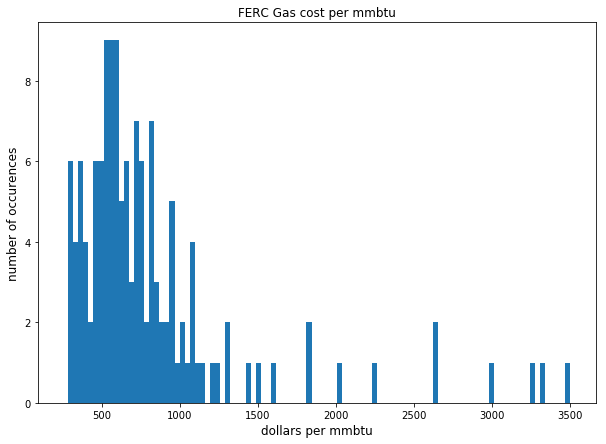

In [168]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 250,3500)

The third population is between .002 and .0175 - off by a factor of 1000.

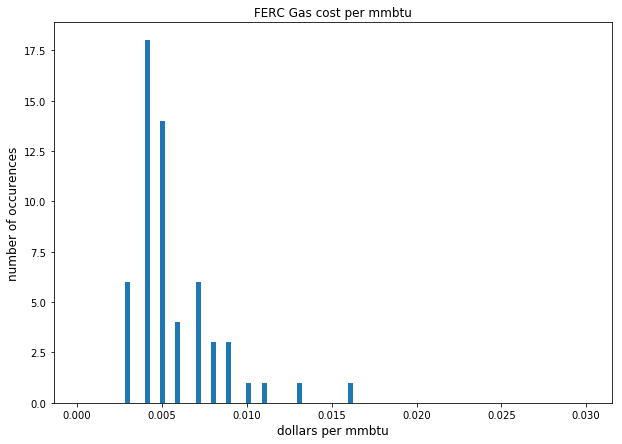

In [169]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu',.0001,.03)

With the except of two records, all of these values are also attributable to utility `respondent_id` 130.

In [149]:
gas[(gas.fuel_cost_per_mmbtu > .0001) & (gas.fuel_cost_per_mmbtu < .02)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
943,944,182,A. Mullergren,2007,gas,mcf,1572.0,1.046000,9.740,9.740,0.013,-25.0,0.000000
1051,1052,130,Horseshoe Lake,2007,gas,mcf,12516345.0,1.037000,6.874,0.000,0.007,78.0,11.690000
1053,1054,130,Seminole,2007,gas,mcf,38693460.0,1.037000,7.232,0.000,0.007,82.0,11.809000
1057,1058,130,Enid,2007,gas,mcf,38850.0,1.037000,6.386,0.000,0.006,151.0,23.672000
1059,1060,130,Muskogee,2007,gas,mcf,3682025.0,1.037000,6.247,0.000,0.006,69.0,11.173000
1060,1061,130,Mustang,2007,gas,mcf,9915051.0,1.037000,6.950,0.000,0.007,72.0,10.677000
1062,1063,130,Mcclain,2007,gas,mcf,18188683.0,1.037000,6.732,0.000,0.007,46.0,7.070000
1600,1601,130,Horseshoe Lake,2008,gas,mcf,9854405.0,1.037000,9.815,0.000,0.009,108.0,11.407000
1601,1602,130,Seminole,2008,gas,mcf,37163017.0,1.037000,8.840,0.000,0.008,98.0,11.594000
1604,1605,130,Enid,2008,gas,mcf,4003.0,1.037000,10.295,0.000,0.010,206.0,20.135000


Applying the two cleaning functions, we see a distribution peaking around 5 dollars per mmbtu with a tail out to 35 dollars per mmbtu.

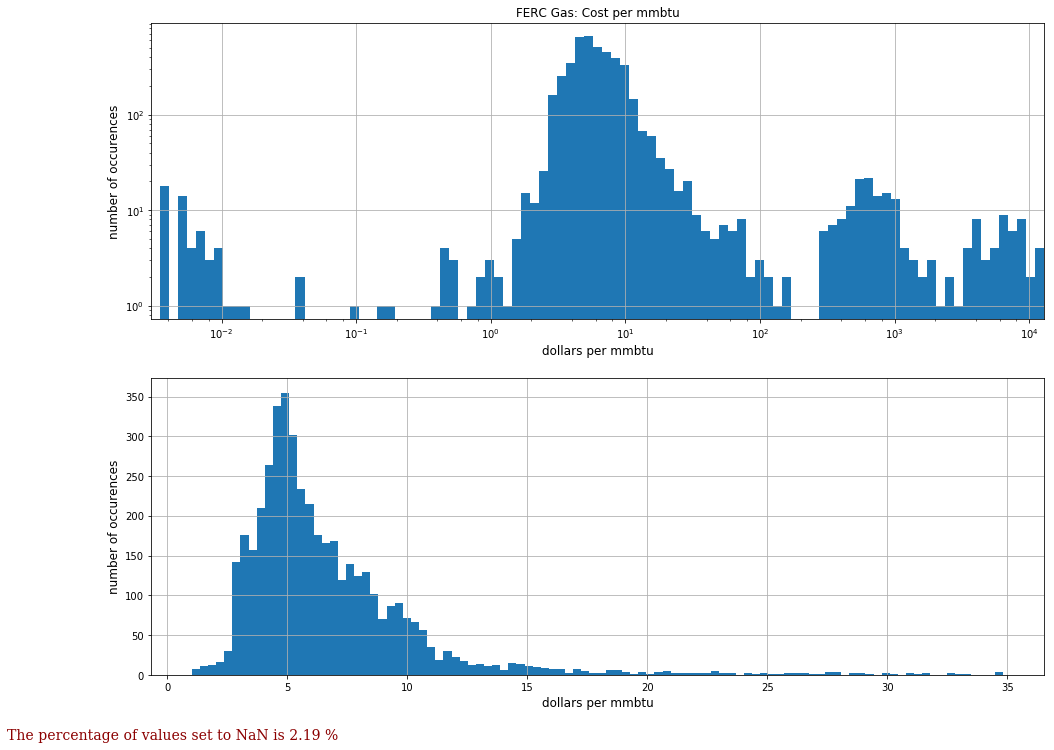

In [136]:
to_fix_cost_per_mmbtu_gas = gas.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_gas = fixit(gas.fuel_cost_per_mmbtu,1,35,[.01,1000])

showfix(to_fix_cost_per_mmbtu_gas,fixed_cost_per_mmbtu_gas,'FERC Gas: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

## Z: Many of of these histograms are probably going to be more meaningful if they are weighted according to the magnitude of the variable being reported -- e.g. quantity of fuel delivered here.  Otherwise a tiny delivery at a ridiculous cost counts just as much as a big delivery at a reasonable cost in the visualization.

## FERC Cost per unit delivered
### FERC Coal cost per unit delivered
Let's take a look at histograms of FERC Form 1 cost per unit delivered for coal. Luckily, most of the fuel units are in tons.

In [179]:
coal.fuel_unit.value_counts()

ton      2958
mmbtu       7
mcf         2
bbl         1
Name: fuel_unit, dtype: int64

We'll drop value below zero.

In [180]:
ferc_coal_cost_delivered = coal[coal.fuel_cost_per_unit_delivered > 0]
ferc_gas_cost_delivered = gas[gas.fuel_cost_per_unit_delivered > 0]

The EIA reports that "The average annual sale prices of coal at mines producing each of the four major ranks of coal in 2015, in dollars per short ton (2,000 pounds)were: Bituminous—51.57, Subbituminous—14.63, Lignite—22.36, Anthracite—97.91..." (https://www.eia.gov/energyexplained/index.cfm?page=coal_prices).

"In 2015, the average sales price of coal at the mine was 31.83 per ton, and the average delivered coal price to the electric power sector was 42.58 per ton, resulting in an average transportation cost of 10.75 per ton, or about 25 percent of the total delivered price."

Looking at EIA data for average coal cost by state from 2008 through 2016, one sees a range from 14 dollars to 190 (for coal shipped to Maine in 2012) dollars per ton (https://drive.google.com/open?id=0B5TMZz2CEFSbcjc5RmVSQUR4LXc).

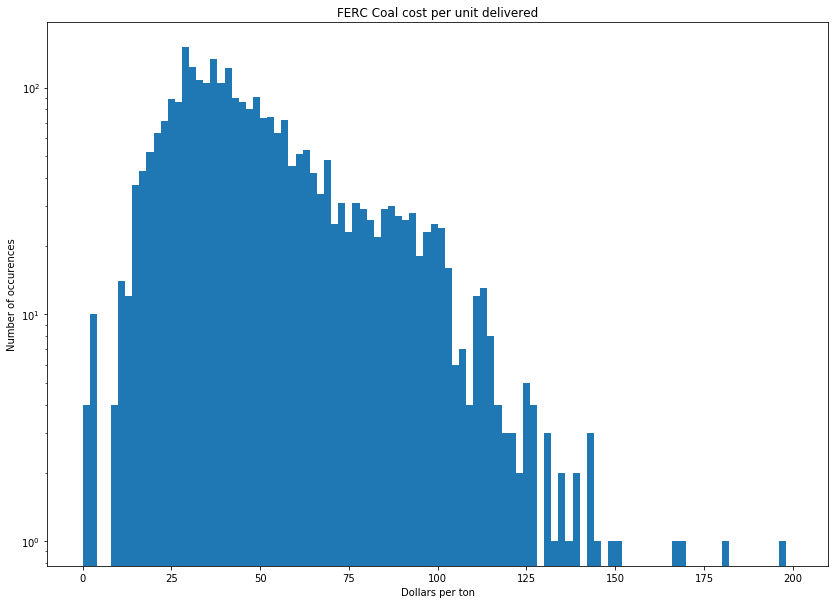

In [186]:
plt.figure(figsize=(14,10))
plt.hist(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered, bins=100,log=True,range=(0,200))
plt.title('FERC Coal cost per unit delivered')
plt.xlabel('Dollars per ton')
plt.ylabel('Number of occurences')
plt.show()

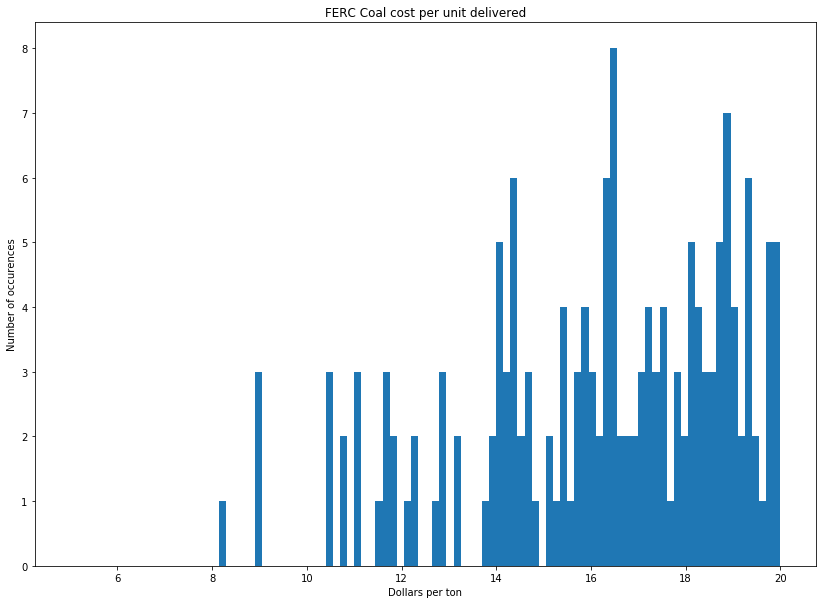

In [181]:
plt.figure(figsize=(14,10))
plt.hist(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(5,20))
plt.title('FERC Coal cost per unit delivered')
plt.xlabel('Dollars per ton')
plt.ylabel('Number of occurences')
plt.show()

There are only a handful of values near zero. It appears that these utilities entered the cost per mmbtu rather than the cost per ton. While some have listed mmbtu as the fuel unit, others have not. We could multiply these by the corrected average heat content per unit to get the price per ton but since it's a small population we will not worry about it for now.

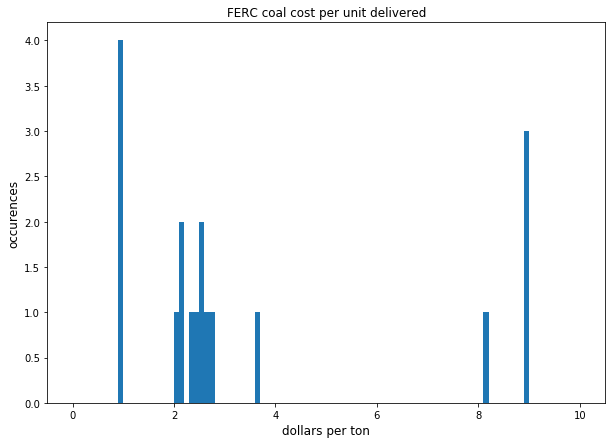

In [174]:
simplegraph(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered,'dollars per ton',\
           'occurences','FERC coal cost per unit delivered',0,10)

In [177]:
ferc_coal_cost_delivered[ferc_coal_cost_delivered.fuel_cost_per_unit_delivered < 10]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
651,652,62,Scherer,2007,coal,mmbtu,16661466.0,0.011963,2.020,2.048,2.011,2052.0,10.206
1228,1229,12,Osage,2007,coal,ton,240865.0,0.007906,8.920,8.920,1.000,16.0,16.299
1229,1230,12,Neil Simpson Complex,2007,coal,ton,642797.0,0.007985,9.810,8.910,0.610,8.0,12.452
1231,1232,12,Wyodak - Bhp 20% She,2007,coal,ton,410016.0,0.007831,9.270,8.920,0.590,6780.0,11.452
2145,2146,62,Scherer,2008,coal,mmbtu,13018186.0,0.011945,2.083,2.173,2.094,2161.0,10.535
4007,4008,62,Scherer,2009,coal,mmbtu,1471202.0,0.011955,2.133,2.130,2.112,2127.0,10.073
5521,5522,62,Scherer,2010,coal,ton,12786515.0,0.011949,2.240,2.379,2.279,2330.0,10.230
6244,6245,403,Wygen Ii,2011,coal,ton,519300.0,0.007862,15.590,0.960,1.030,13.0,12.106
6273,6274,12,Wygen Iii,2011,coal,ton,596017.0,0.007854,8.750,8.170,0.000,12.0,13.397
6923,6924,62,Scherer,2011,coal,ton,15945277.0,0.011958,2.432,2.433,2.403,2520.0,10.496


There are only 4 values above 200.

In [187]:
ferc_coal_cost_delivered[ferc_coal_cost_delivered.fuel_cost_per_unit_delivered > 200]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
4193,4194,122,Colstrip 4,2010,coal,ton,1138599.0,0.008430,44033.320,44033.320,0.948,10.0,10.941253
7616,7617,17,H.B. Robinson,2012,coal,ton,98417.0,0.011877,137.522,222.696,5.790,65.0,10.932000
8148,8149,57,Mitchell,2012,coal,ton,1545.0,0.000000,433.265,433.265,17.280,-325.0,-18.832766
8160,8161,57,Mcintosh,2012,coal,ton,839.0,0.000000,266.219,266.219,0.000,-17.0,0.000000


Since we don't have quantity delivered values, we weight the cost delivered data by quantity burned.

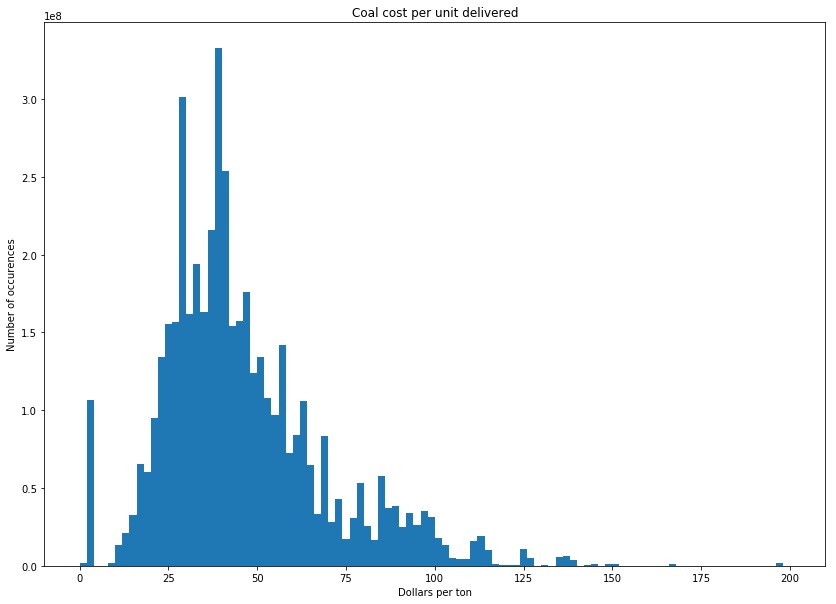

In [189]:
plt.figure(figsize=(14,10))
plt.hist(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered,\
         weights=ferc_coal_cost_delivered.fuel_qty_burned, bins=100,range=(0,200))
plt.title('Coal cost per unit delivered')
plt.xlabel('Dollars per ton')
plt.ylabel('Number of occurences')
plt.show()

Let's use the cleaning functions to limit the data to the EIA state average values with a minimum of 14 and a maximum of 190.

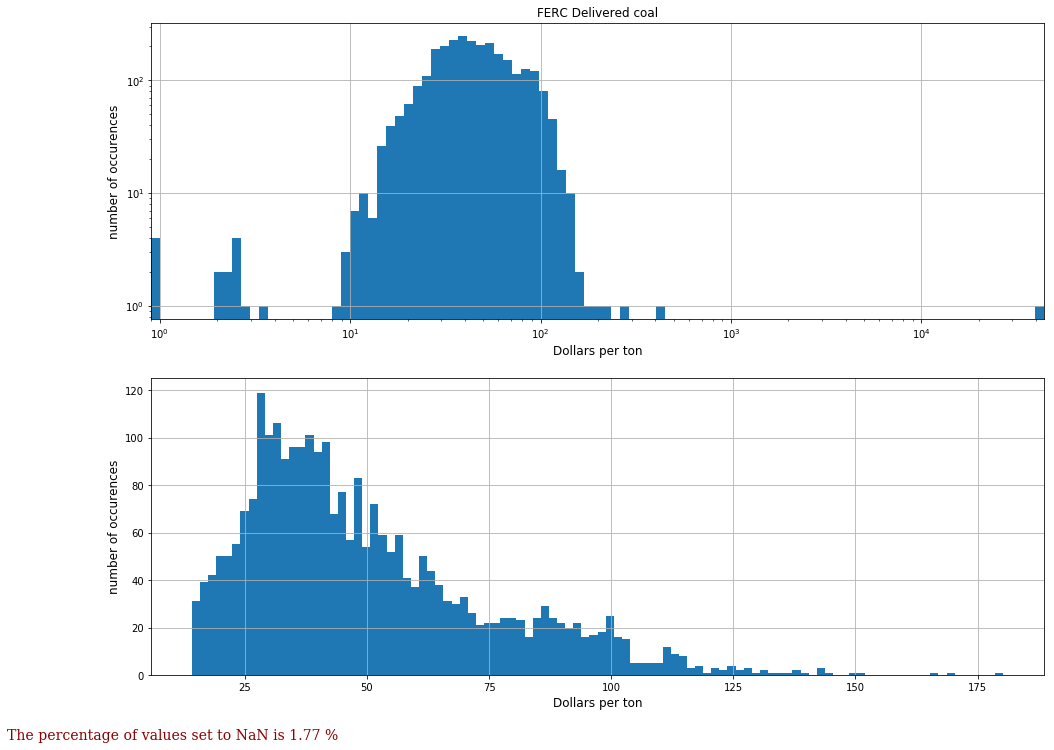

In [263]:
ferc_delivered_coal = fixit(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered, 14, 190, [1])
showfix(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered,ferc_delivered_coal,'FERC Delivered coal',\
       'Dollars per ton','number of occurences')

### FERC Gas cost per unit delivered

Given that there's rougly 1 mmbtu per mcf of natural gas (on average 1.032 mmbtu according to EIA (https://www.eia.gov/tools/faqs/faq.php?id=45&t=8), the distribution for gas costs delivered should be very similar to that of the cost per mmbtu. The bounds for dollars per mmbtu from EIA data were from 1 to 35 dollars. Let's start with the primary distribution:

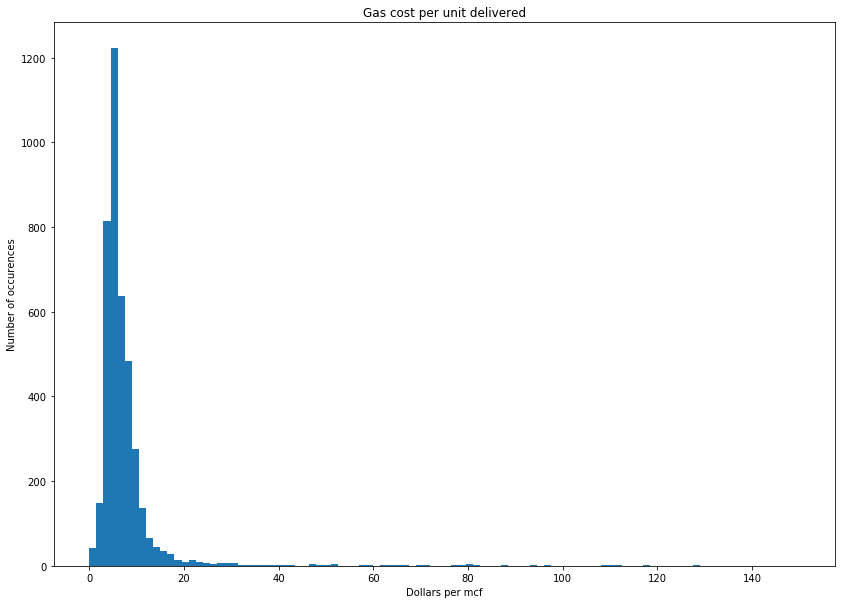

In [197]:
plt.figure(figsize=(14,10))
plt.hist(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,150))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()

It looks like there are two outlying populations - one that's 100 times too big and one that's 100 times too small. The one that's 100 times too big appears to be a dollars and cents issue - however it is only  few records. Both are less than a percentage point so we will not worry about including either population.

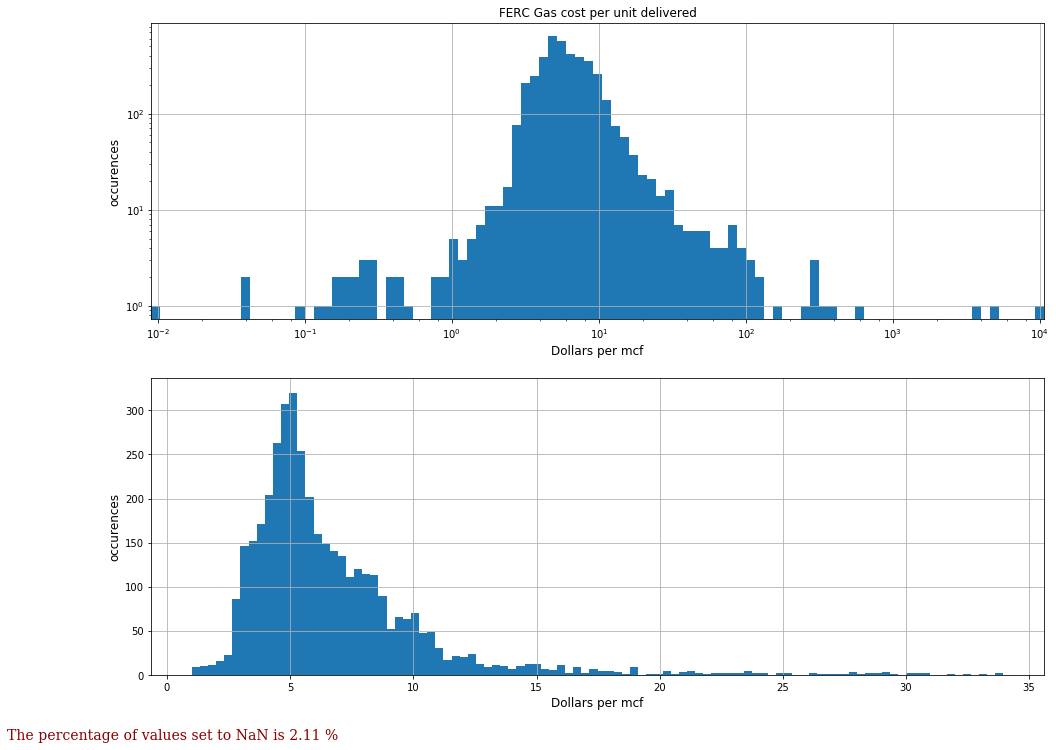

In [262]:
ferc_delivered_gas = fixit(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered, 1, 35, [1])
showfix(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered,ferc_delivered_gas,'FERC Gas cost per unit delivered',\
       'Dollars per mcf','occurences')

Looking at the smaller of the two populations, it does not appear to mirror the main population and it's not clear what would make the population 100 times too small.

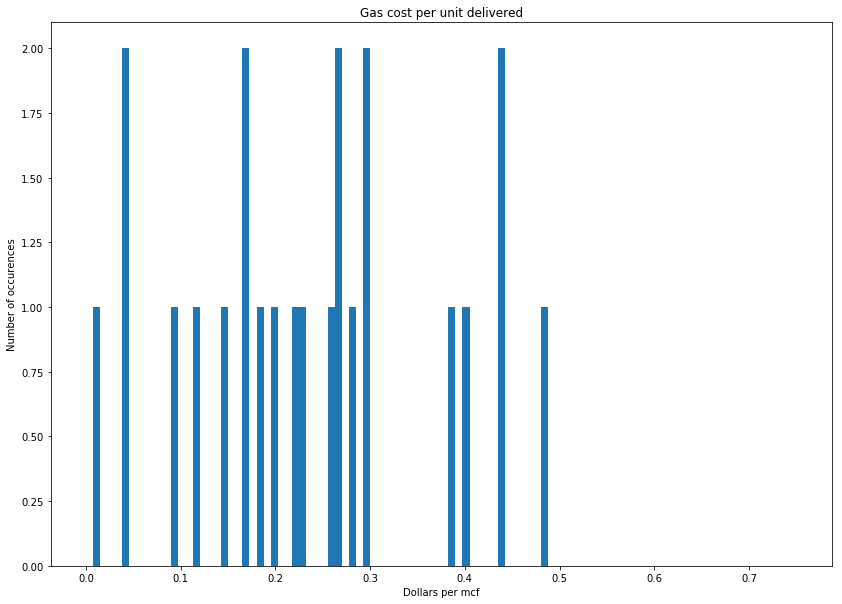

In [222]:
plt.figure(figsize=(14,10))
plt.hist(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,.75))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()

In [219]:
ferc_gas_cost_delivered[(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered > 0) & (ferc_gas_cost_delivered.fuel_cost_per_unit_delivered > 1)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
1,2,186,Altavista,2007,gas,mcf,24908.0,0.001040,11.090,12.140,14.090,0.0,0.000000
3,4,186,Bellemeade,2007,gas,mcf,3415467.0,0.001029,8.157,8.690,14.010,80.0,9.374000
13,14,186,Darbytown,2007,gas,mcf,1423188.0,0.001027,7.864,7.840,7.660,97.0,12.523000
15,16,186,Gordonsville,2007,gas,mcf,3381835.0,0.001041,8.305,8.690,12.420,69.0,8.330000
17,18,186,Gravel Neck,2007,gas,mcf,861042.0,0.001040,7.807,7.730,7.510,94.0,12.414000
19,20,186,Ladysmith,2007,gas,mcf,1962619.0,0.001027,8.361,8.360,8.140,90.0,10.849000
27,28,186,North Branch,2007,gas,bbl,263946.0,0.091800,63.590,65.990,16.340,0.0,0.000000
30,31,186,Possum Point,2007,gas,mcf,2912413.0,0.001045,6.230,8.020,5.970,75.0,0.000000
31,32,186,Remington,2007,gas,mcf,1602849.0,0.001041,9.130,8.970,8.780,95.0,10.780000
39,40,186,Possum Point Com Cyc,2007,gas,mcf,15793061.0,0.001046,8.356,8.020,8.010,61.0,0.000000


There are only a handful of values above 100. It appears that some but not all of these are off by a factor of 100 because the utility entered cents rather than dollars.

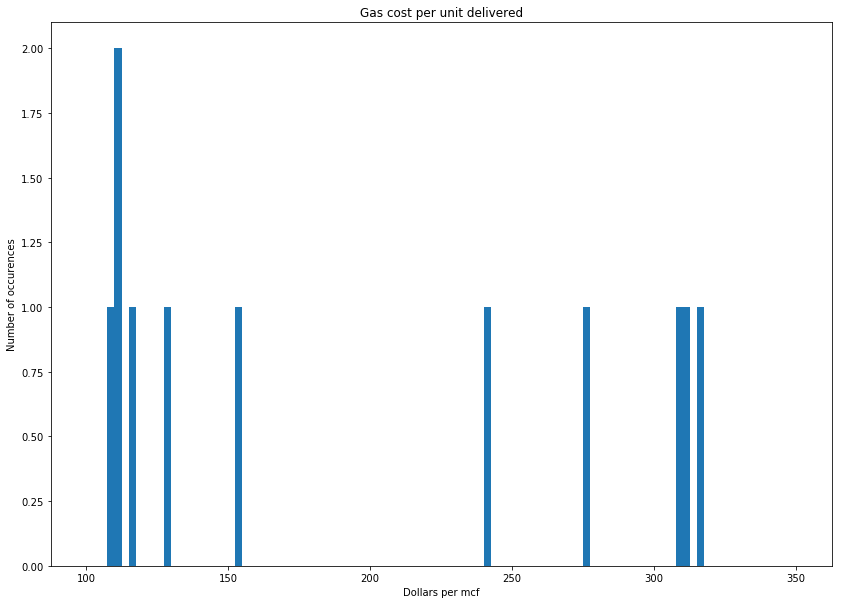

In [221]:
plt.figure(figsize=(14,10))
plt.hist(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(100,350))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()

In [211]:
ferc_gas_cost_delivered[ferc_gas_cost_delivered.fuel_cost_per_unit_delivered > 100]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
1427,1428,122,Huron Gt,2008,gas,mmbtu,3386.0,0.001000,10490.000,10490.000,3.552,-296.0,-0.028217
2247,2248,195,Plant Total-Weston,2008,gas,mcf,308175.0,0.001005,10.900,117.270,10.834,106.0,0.000000
2306,2307,193,Germantown-Total,2008,gas,mcf,5436.0,0.001010,371.822,371.822,876.527,13000.0,0.000000
3416,3417,89,M34/Marinette,2009,gas,mcf,2960.0,0.001004,110.997,110.997,110.586,1460.0,13.204000
3708,3709,193,Germantown-Total,2009,gas,mcf,1645.0,0.001010,276.945,276.945,652.872,14889.0,0.000000
4812,4813,176,Sundt,2010,gas,mcf,17780.0,0.001020,315.681,315.681,309.491,4930.0,15.929000
4913,4914,151,Allegany Station 133,2010,gas,mcf,344735.0,0.001027,5.658,4946.000,6.054,55.0,7.552899
5077,5078,45,Riverbend,2010,gas,mcf,13.0,1.017000,561.308,561.308,561.308,0.0,0.000000
5828,5829,19,West Coxsackie,2011,gas,mcf,14224.0,0.001027,10670.000,10670.000,10386.000,156.0,15.000000
9257,9258,42,Conesville,2013,gas,bbl,183.0,0.136781,128.474,127.709,22.364,0.0,0.000000


Since we don't have quantity delivered values, we weight the graph above by quantity burned. This distribution also appears to fit nicely with the EIA 923 bounds of 1 and 35.

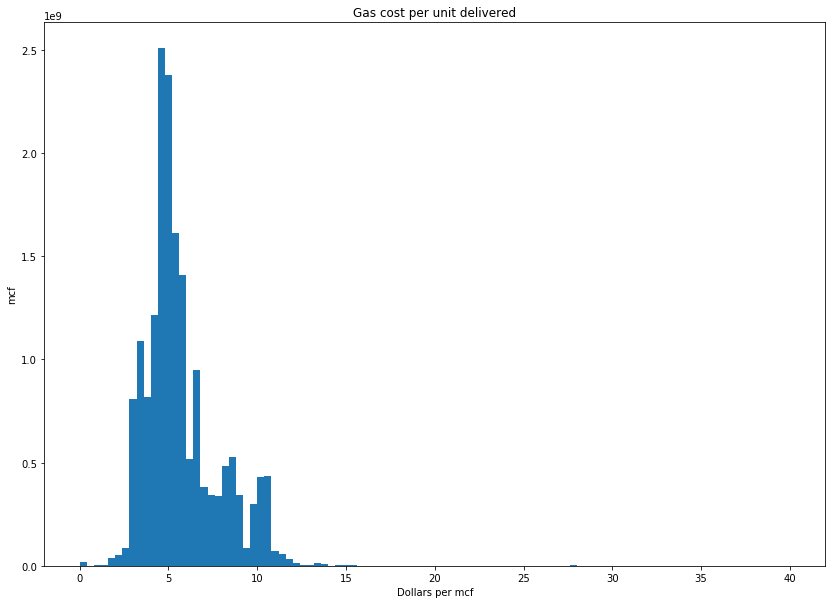

In [240]:
plt.figure(figsize=(14,10))
plt.hist(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered,\
         weights=ferc_gas_cost_delivered.fuel_qty_burned,bins=100,range=(0,40))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('mcf')
plt.show()

## FERC Cost per unit burned
### FERC Coal cost per unit burned
Let's take a look at histograms for FERC cost per unit burned for coal. We can rely on the same range of values used for the cost of fuel delivered. We expect that the values will be very similar to the results for cost per unit delivered.

In [251]:
ferc_coal_cost_burned = coal[coal.fuel_cost_per_unit_burned > 0]
ferc_gas_cost_burned = gas[gas.fuel_cost_per_unit_burned > 0]

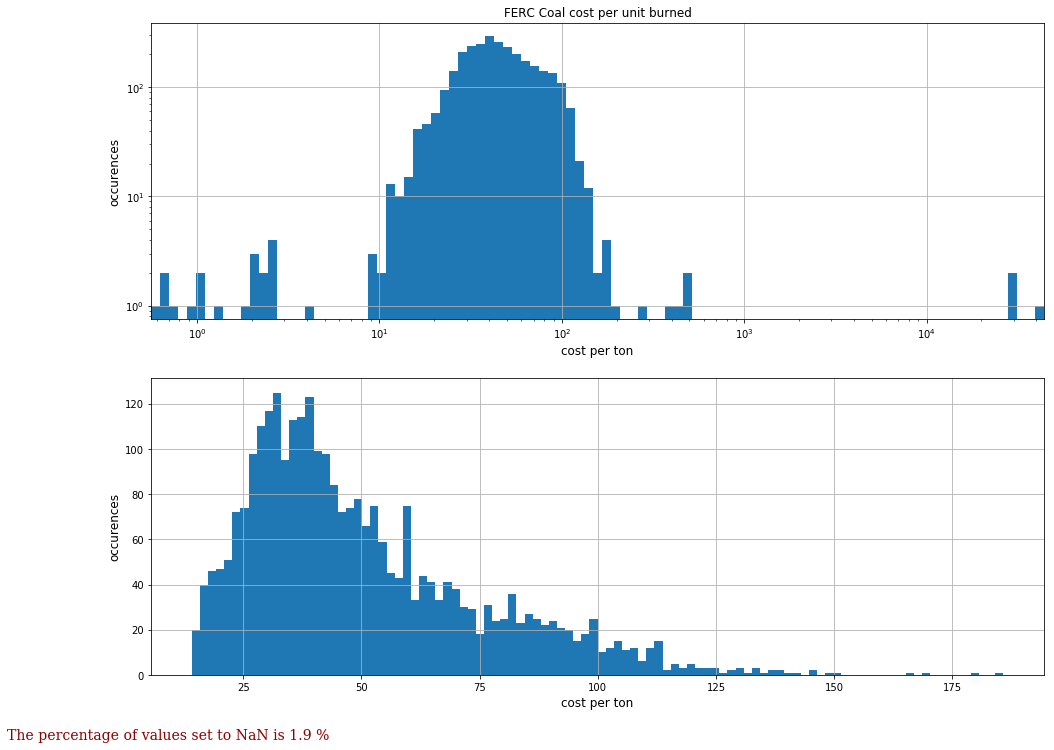

In [254]:
ferc_coal_burned_fixed = fixit(ferc_coal_cost_burned.fuel_cost_per_unit_burned, 14, 190, [1])
showfix(ferc_coal_cost_burned.fuel_cost_per_unit_burned,ferc_coal_burned_fixed, \
        'FERC Coal cost per unit burned','cost per ton','occurences')

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


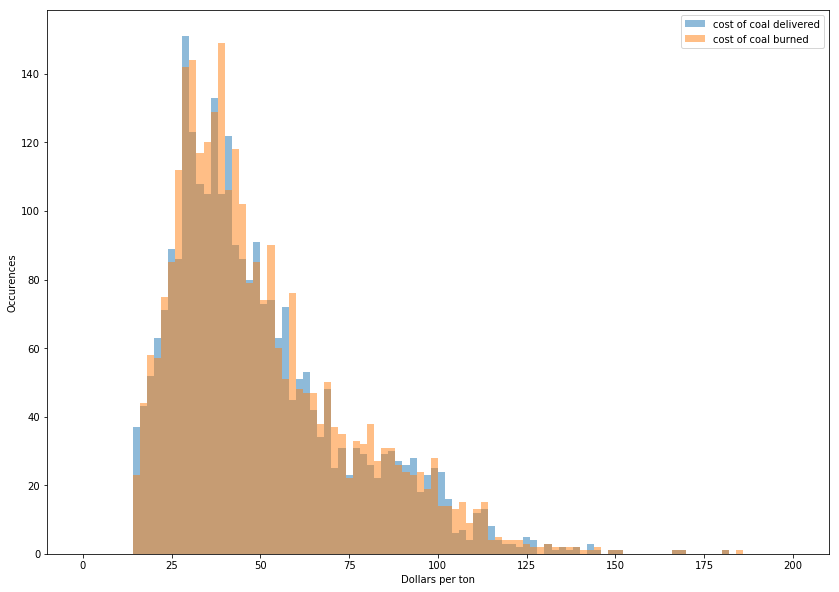

In [269]:
plt.figure(figsize=(14,10))
plt.hist(ferc_delivered_coal,bins=100, range=(0,200),alpha=.5,label='cost of coal delivered')
plt.hist(ferc_coal_burned_fixed,bins=100, range=(0,200),alpha=.5,label='cost of coal burned')
plt.xlabel('Dollars per ton')
plt.ylabel('Occurences')
plt.legend()
plt.show()

As expected, there is great overlap between the two distributions. Given the lag between fuel delivery and fuel consumption, it is not surprising that they are not precisely the same.

### FERC Gas cost per unit burned
Let's take a look at histograms for FERC cost per unit burned for gas. Again, we can rely on the same range of values used for the cost of fuel delivered. We expect that the values will be very similar to the results for cost per unit delivered.

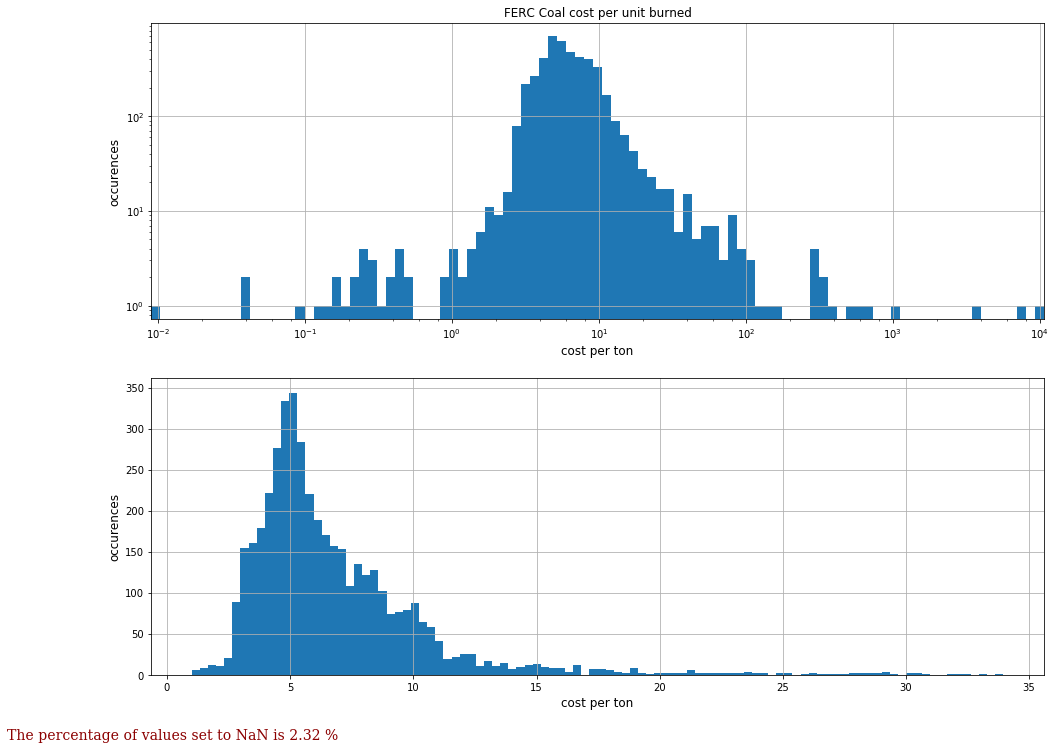

In [270]:
ferc_gas_burned_fixed = fixit(ferc_gas_cost_burned.fuel_cost_per_unit_burned, 1, 35, [1])
showfix(ferc_gas_cost_burned.fuel_cost_per_unit_burned,ferc_gas_burned_fixed, \
        'FERC Coal cost per unit burned','cost per ton','occurences')

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


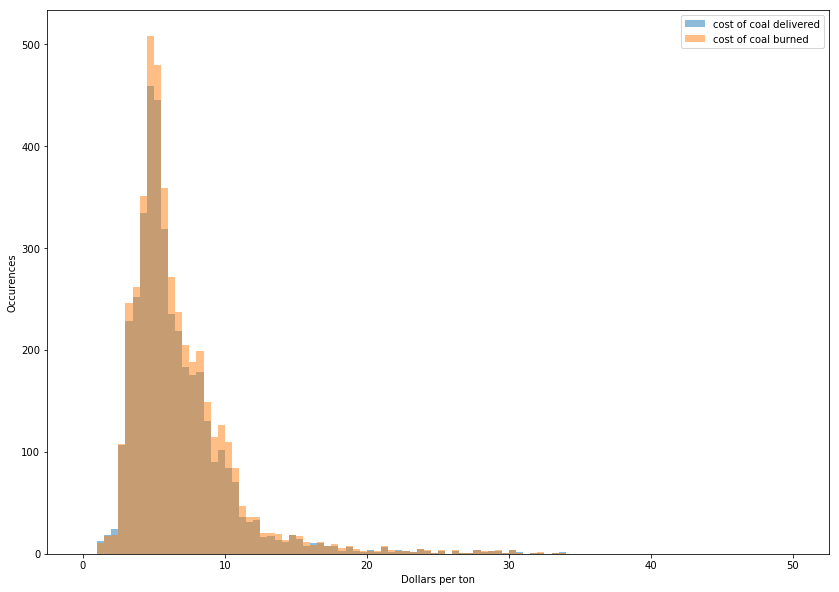

In [278]:
plt.figure(figsize=(14,10))
plt.hist(ferc_delivered_gas,bins=100, range=(0,50),alpha=.5,label='cost of coal delivered')
plt.hist(ferc_gas_burned_fixed,bins=100, range=(0,50),alpha=.5,label='cost of coal burned')
plt.xlabel('Dollars per ton')
plt.ylabel('Occurences')
plt.legend()
plt.show()

Once again, there's considerable overlap between the cost of fuel delivered and the cost of fuel burned.

### Heat rate (mmbtu per kWh or MWh) in both EIA 923 and FERC Form 1
We'll start with looking at the range of heat rates in EIA 923. EIA 923 appears to be more orderly than the FERC data and the EIA data may be helpful in determining what the bounds of the main population should be. Once we have an idea from EIA 923 about where the main population begins and ends, we can apply the lower and upper bounds to the FERC Form 1 data and use the multipliers in our cleaning function to bring outlying populations into the main population of FERC heat rate data.

First we'll select the data from EIA 923 and calculate the heat rate.

In [41]:
## Select the Generation Fuel table from EIA 923
mwh_eia923 = pd.read_sql('''SELECT * FROM generation_fuel_eia923''', pudl_engine)

In [43]:
mmwh_eia923

,id,plant_id,report_date,nuclear_unit_id,fuel_type,aer_fuel_type,aer_fuel_category,prime_mover,fuel_consumed_total,fuel_consumed_for_electricity,fuel_mmbtu_per_unit,fuel_consumed_total_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh
0,1,2,2011-01-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,109912.0,109912.0,11312.437
1,2,2,2011-01-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,299680.0,299680.0,31492.274
2,3,2,2011-01-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,227955.0,227955.0,23892.124
3,4,2,2011-01-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,65868.0,65868.0,6926.232
4,5,2,2011-01-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,30594.0,30594.0,3282.922
5,6,2,2011-02-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,88327.0,88327.0,9090.908
6,7,2,2011-02-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,203461.0,203461.0,21380.920
7,8,2,2011-02-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,230140.0,230140.0,24121.203
8,9,2,2011-02-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,60389.0,60389.0,6350.080
9,10,2,2011-02-01,NaN,WAT,HYC,hydro,HY,0.0,0.0,0.0,19658.0,19658.0,2109.496


/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


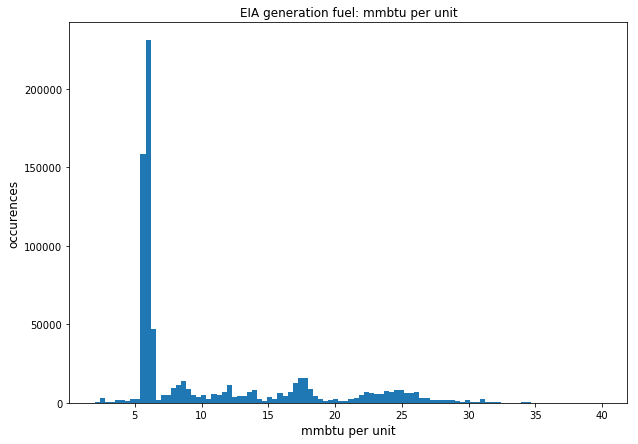

In [162]:
flexiblegraph(mwh_eia923.fuel_mmbtu_per_unit,'mmbtu per unit','occurences','EIA generation fuel: mmbtu per unit','linear',2,40,100)

## Z: I'm pretty sure that selections and groupby stuff can be done using the DateTime objects natively rather than grafting on additional columns.  It's a different process though.

In [11]:
## Add a column for the year in order to get annual heat rate data
mwh_eia923['year'] = pd.DatetimeIndex(mwh_eia923['report_date']).year
# Summarize data by year for each plant; this creates a new column that reports the annual sum in each row
mwh_eia923["fuel_consumed_total_mmbtu_sum"] = mwh_eia923.groupby(["plant_id", "year"])["fuel_consumed_total_mmbtu"].transform(sum)
mwh_eia923["net_generation_mwh_sum"] = mwh_eia923.groupby(["plant_id", "year"])["net_generation_mwh"].transform(sum)

In [12]:
# Use sum of fuel_consumed_total_mmbtu_sum and net_generation_mwh_sum to calculate annual heat rate 
# for each plant id
mwh_eia923['calculated_heat_rate_btu_per_kwh'] = \
((mwh_eia923['fuel_consumed_total_mmbtu_sum']*1e6)/(mwh_eia923['net_generation_mwh_sum']*1e3))

### Analyzing the EIA 923 heat rate data
Let's look at the quantiles and histograms for heat rate data from EIA 923 for coal and gas respectively.

In [13]:
mwh_eia923_coal = mwh_eia923[(mwh_eia923.aer_fuel_category == 'coal')]
mwh_eia923_coal.calculated_heat_rate_btu_per_kwh.quantile(q=[.01,.05,.95,.99])

0.01     7333.860712
0.05     9261.694468
0.95    27619.408928
0.99    39663.152219
Name: calculated_heat_rate_btu_per_kwh, dtype: float64

In [14]:
mwh_eia923_gas = mwh_eia923[(mwh_eia923.aer_fuel_category == 'gas')]
mwh_eia923_gas.calculated_heat_rate_btu_per_kwh.quantile(q=[.01,.05,.95,.99])

0.01     2213.432967
0.05     6282.368575
0.95    26597.569494
0.99    41953.204147
Name: calculated_heat_rate_btu_per_kwh, dtype: float64

We expect to find heat rates for coal power plants clustered around 10,000 btu per kwh (per EIA annual data https://www.eia.gov/electricity/annual/html/epa_08_02.html). We expect to find heat rates for gas power plants clustered around 11,000 and 7,500 for combustion turbines and combined cycle plants respectively.

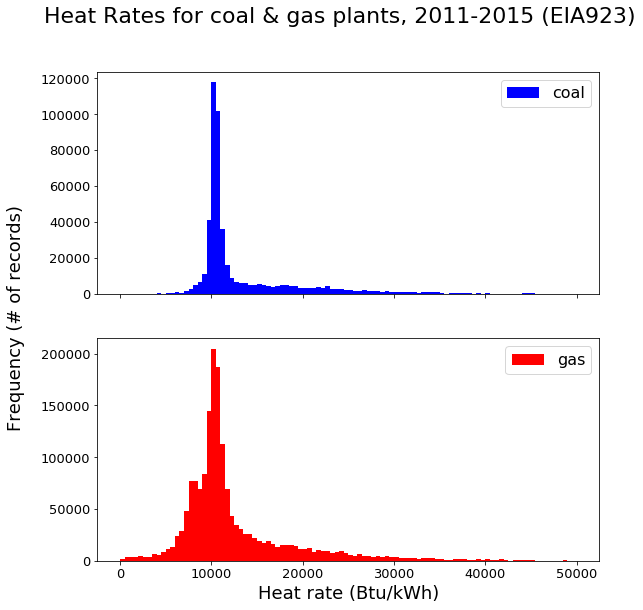

In [15]:
# Plot heat rate histogram for full data set by fuel type
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(mwh_eia923_coal.calculated_heat_rate_btu_per_kwh, color= 'b', label='coal', range=(0,50000), bins=100)
ax1.legend(loc="upper right", fontsize=16)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.hist(mwh_eia923_gas.calculated_heat_rate_btu_per_kwh, color= 'r', label='gas', range=(0,50000), bins=100)
ax2.legend(loc="upper right", fontsize=16)
plt.suptitle('Heat Rates for coal & gas plants, 2011-2015 (EIA923)', size=22)
ax2.set_xlabel('Heat rate (Btu/kWh)', size=18)
f.text(0.0, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', size=18)
f.set_size_inches(9,9)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

### FERC Heat rates
Let's take a look at the FERC Form 1 heat rate data for coal and gas, respectively. For each data set, we'll begin by removing the values at or below zero. 

In [316]:
coal_above_zero = coal[coal.fuel_mmbtu_per_mwh > 0]
gas_above_zero = gas[gas.fuel_mmbtu_per_mwh > 0]

Let's take a look at the main distribution of coal heat rate values.

The main distribution appears to begin just after 5.

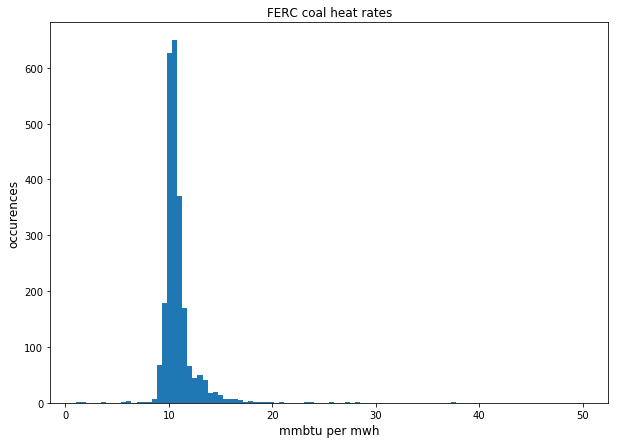

In [332]:
simplegraph(coal_above_zero.fuel_mmbtu_per_mwh,'mmbtu per mwh','occurences','FERC coal heat rates',1,50)

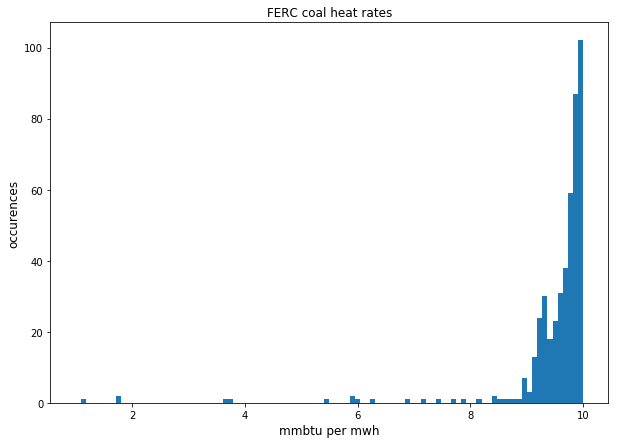

In [325]:
simplegraph(coal_above_zero.fuel_mmbtu_per_mwh,'mmbtu per mwh','occurences','FERC coal heat rates',1,10)

The main distribution appears to drop of significantly around 15 and with a tail extending to (or past) 30.

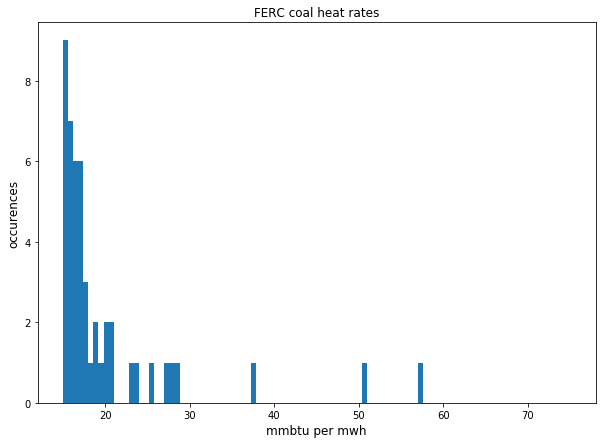

In [351]:
simplegraph(coal_above_zero.fuel_mmbtu_per_mwh,'mmbtu per mwh','occurences','FERC coal heat rates',15,75)

There are two other populations of coal heat rate values:
- one population clustered around .01. These values appear to off by a factor of 1000 times too low, as the net generation was likely entered in kWh rather than MWh.
- one population clustered around 10000. These values appear to be off by a factor of 1000 times too high. There are only six values, unclear why.

Let's take a look at the low population.

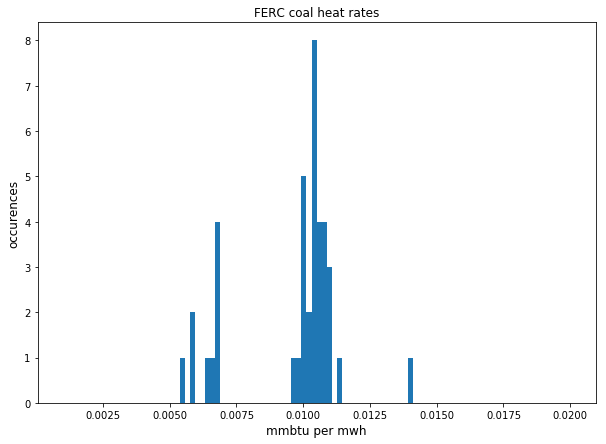

In [341]:
simplegraph(coal_above_zero.fuel_mmbtu_per_mwh,'mmbtu per mwh','occurences','FERC coal heat rates',.001,.02)

In [ ]:
lower_population = coal_above_zero[(coal_above_zero.fuel_mmbtu_per_mwh > .005) \
                & (coal_above_zero.fuel_mmbtu_per_mwh < .015)]
lower_population.sort_values('fuel_mmbtu_per_mwh')

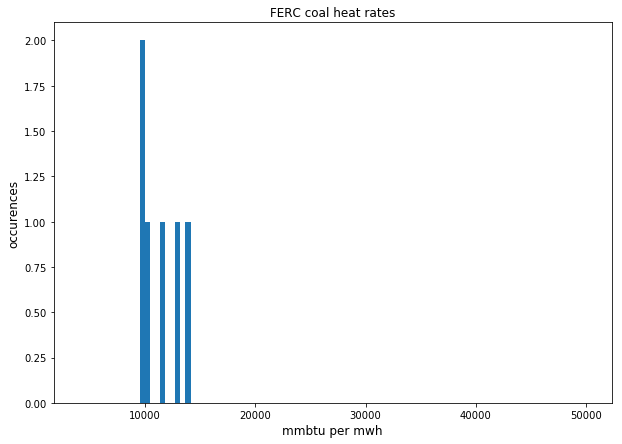

In [343]:
simplegraph(coal_above_zero.fuel_mmbtu_per_mwh,'mmbtu per mwh','occurences','FERC coal heat rates',4000,50000)

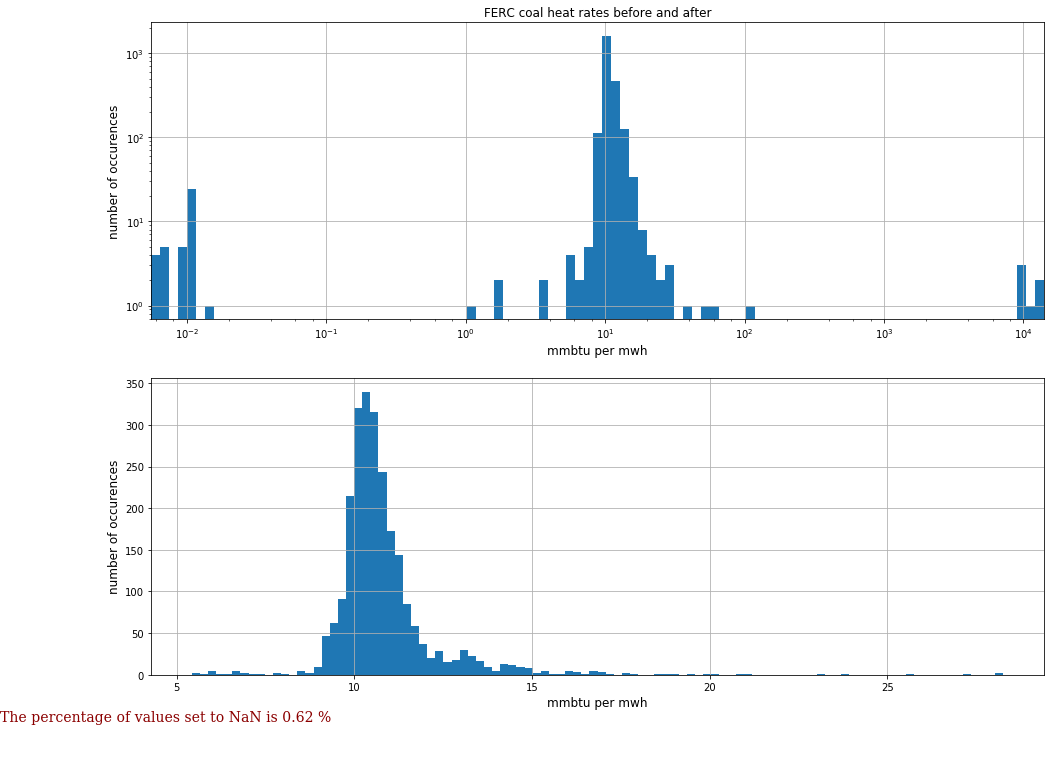

In [366]:
coal_fix = fixit(coal_above_zero.fuel_mmbtu_per_mwh,5,30,[1000])
showfix(coal.fuel_mmbtu_per_mwh,coal_fix,'FERC coal heat rates before and after','mmbtu per mwh','number of occurences')

Look at gas heat rates, we should expect to see two peaks around 7 and 10. The main distribution appears to begin just after 2.5 and peters out around 65.

## Z: Again, no magic numbers 1.173, 52.207 (Why so specific?) and why 1000, 0.001?  Also, why are there two peaks in the cleaned up version of the data?  What does it mean?

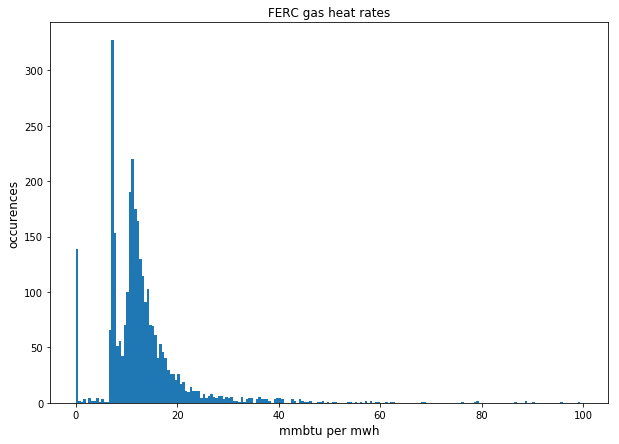

In [381]:
flexiblegraph(gas_above_zero.fuel_mmbtu_per_mwh,'mmbtu per mwh',\
            'occurences','FERC gas heat rates','linear',0,100,200)

Looking at the low end of the main population:

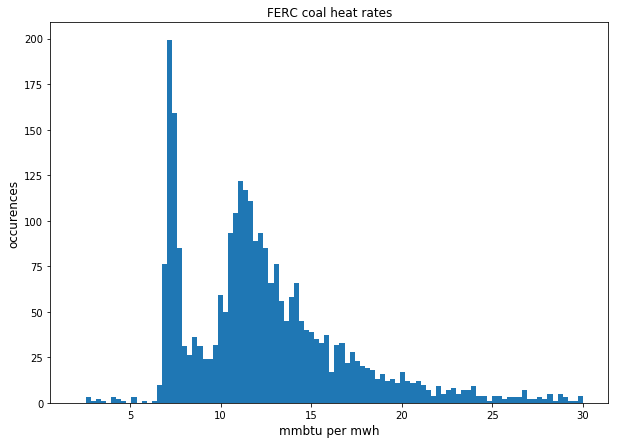

In [369]:
simplegraph(gas_above_zero.fuel_mmbtu_per_mwh,'mmbtu per mwh',\
            'occurences','FERC gas heat rates',2,30)

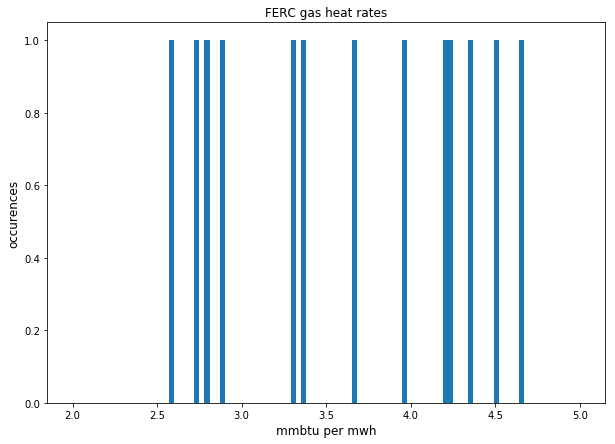

In [372]:
simplegraph(gas_above_zero.fuel_mmbtu_per_mwh,'mmbtu per mwh',\
            'occurences','FERC gas heat rates',2,5)

Looking at the high end of the population:

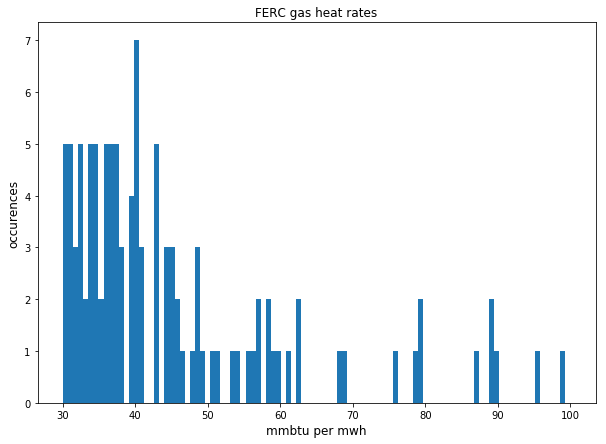

In [385]:
flexiblegraph(gas_above_zero.fuel_mmbtu_per_mwh,'mmbtu per mwh',\
            'occurences','FERC gas heat rates','linear',30,100,100)

There are two other distributions:
- one around .01 that appears to be 1000 times too small, which is likely a utility reporting net generation in kWh rather than MWh
- one around 10000 that appears to be 1000 times to big - this is about 20 values and it's unclear what the error is

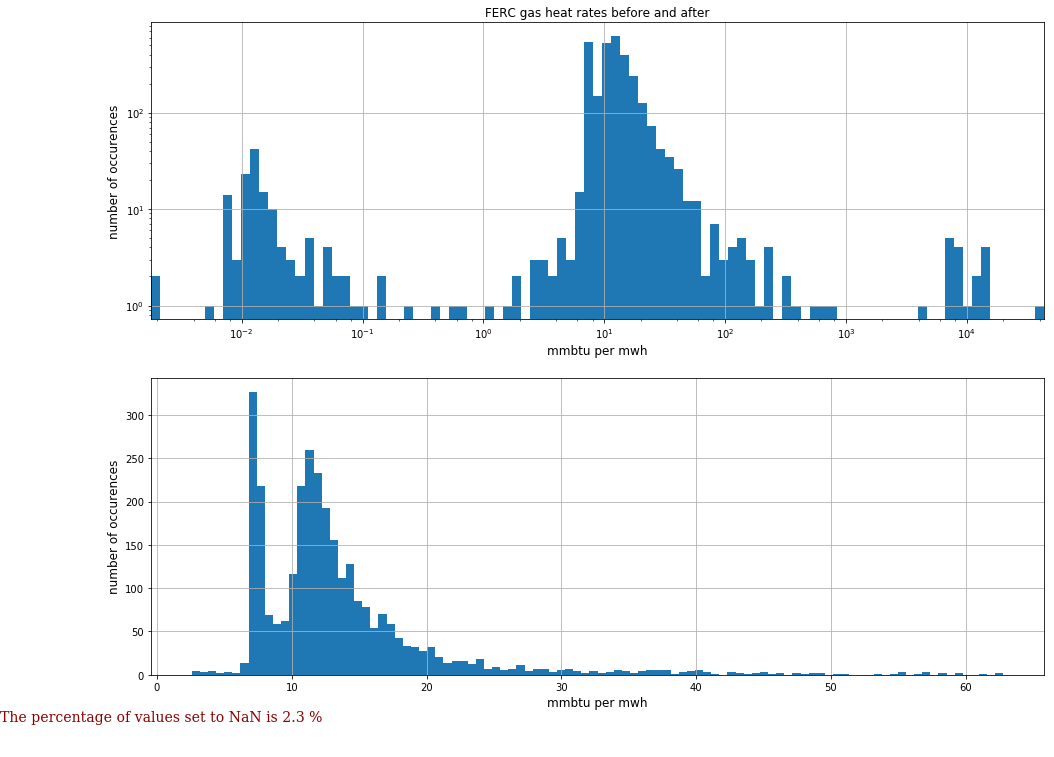

In [395]:
gas_fix = fixit(gas_above_zero.fuel_mmbtu_per_mwh,2.5,65,[1000])
showfix(gas.fuel_mmbtu_per_mwh,gas_fix,'FERC gas heat rates before and after','mmbtu per mwh','number of occurences')

Taking a look at the values of the higher population:

In [392]:
gas[gas.fuel_mmbtu_per_mwh > 1000]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
2884,2885,178,Woodsdale Gt,2009,gas,mcf,1226497.0,0.000001,4.951,4.951,4.816,205.0,43535.000000
5035,5036,130,Muskogee,2010,gas,mcf,958863.0,1.037000,4.556,0.000,0.005,50268.0,10423.890000
7798,7799,147,Reeves,2012,gas,mcf,863253.0,1.027000,3.264,3.277,3.277,44.0,13300.176000
7800,7801,147,Lordsburg Turbine,2012,gas,mcf,135615.0,1.028000,19.947,13.034,13.034,157.0,12015.805000
7801,7802,147,Afton Turbine,2012,gas,mcf,863253.0,1.028000,4.507,4.030,4.030,32.0,7896.654000
7802,7803,147,Luna,2012,gas,mcf,2373436.0,10.272000,4.136,3.839,3.839,29.0,7640.466000
8754,8755,147,Reeves,2013,gas,mcf,1238982.0,0.000001,4.275,4.154,4.154,57.0,13658.173000
8756,8757,147,Lordsburg Turbine,2013,gas,mcf,81429.0,0.000001,32.173,19.119,19.119,295.0,15408.636000
8757,8758,147,Afton Turbine,2013,gas,mcf,5059071.0,0.000001,4.795,4.493,4.494,35.0,7715.519000
8758,8759,147,Luna,2013,gas,mcf,2573684.0,0.000001,5.301,4.701,4.701,36.0,7712.267000


### Fuel Cost per MWh for EIA and FERC

Let's take a look at fuel cost per MWh for EIA and FERC. We'll start with EIA and use the quantiles from EIA to bound the range of reasonable vales in FERC. WE'll begin by pulling the necessary columns from EIA 923 fuel receipts and costs.

In [42]:
fuel_rc = pd.read_sql('''SELECT fuel_quantity,energy_source, fuel_group, average_heat_content, fuel_cost, plant_id, report_date \
FROM fuel_receipts_costs_eia923''', con = pudl_engine)

We'll then convert the report date into years and months, and convert the fuel_cost column from cents to dollars.
## Z: again, I understand that the year/month things are easy for now, but we ought to figure out how to do the same thing with Date objects if we can and it's straightforward.

In [64]:
fuel_rc['year'] = pd.DatetimeIndex(fuel_rc['report_date']).year
fuel_rc['month'] = pd.DatetimeIndex(fuel_rc['report_date']).month
fuel_rc['fuel_cost'] = fuel_rc['fuel_cost'] * .01

In [65]:
fuel_rc.sample(5)

,fuel_quantity,energy_source,fuel_group,average_heat_content,fuel_cost,plant_id,report_date,year,month
81635,2000.0,NG,Natural Gas,1.021,NaN,55320,2012-07-01,2012,7
26217,19948.0,BIT,Coal,23.224,2.227,6018,2011-06-01,2011,6
134859,14579.0,SUB,Coal,16.672,2.117,127,2014-01-01,2014,1
11335,7934.0,NG,Natural Gas,1.020,4.044,2964,2011-03-01,2011,3
153514,64.0,NG,Natural Gas,1.031,5.272,56564,2014-06-01,2014,6


In [66]:
eia_rc_coal = fuel_rc[fuel_rc.fuel_group == 'Coal']

In [75]:
eia_rc_gas = fuel_rc[fuel_rc.fuel_group == 'Natural Gas']

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


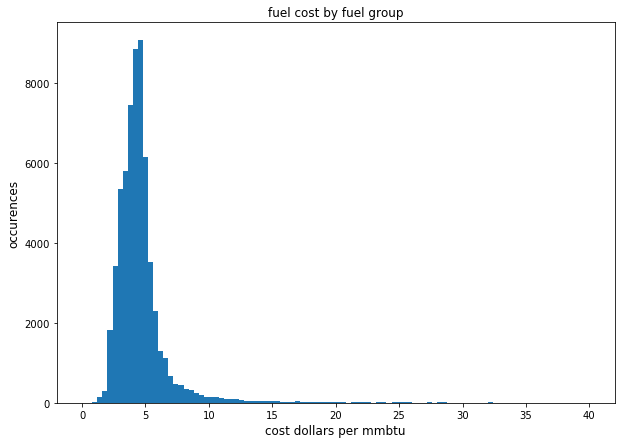

In [106]:
simplegraph(eia_rc_gas.fuel_cost,"cost dollars per mmbtu","occurences","fuel cost by fuel group",0,40)

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


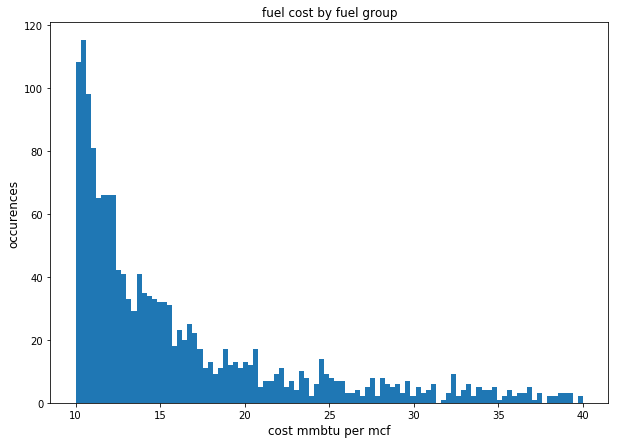

In [92]:
simplegraph(eia_rc_gas.fuel_cost,"cost mmbtu per mcf","occurences","fuel cost by fuel group",10,40)

We'll find sum the mmbtus per delivery and group them by fuel type. When we sort from lowest to highest, we'll know which fuel type is the dominant fuel type for the plant (the fuel type of last entry). 
## Z: I think this part where you're starting to group and sum stuff could use some additional explanation. Also I feel kinda iffy about just choosing the majority fuel (or even plurality fuel?) to determine the "real" fuel type.  Why is this necessary? Why not just look at all the coal and all the gas deliveries independently?

In [31]:
fuel_rc['mmbtu_per_delivery'] = fuel_rc['fuel_quantity'] * fuel_rc['average_heat_content']
fuel_rc['annual_mmbtu_by_fuel'] = fuel_rc.groupby(['plant_id','year','fuel_group'])\
['mmbtu_per_delivery'].transform(sum)
fuel_rc.sort_values(['annual_mmbtu_by_fuel'],inplace=True)

We'll find the cost of each delivery and sum all the deliveries for each plant in each year.
## Z: Why do we need to sum across all the deliveries for a plant in a year? Everything below here is confusing... Why is anything being broken out by year? It doesn't seem like things get segmented by year later for plotting or analysis. Why not just do it all in one swoop?  Why is it being broken out by plant_id when what you want to do is calculate a metric by fuel?

In [32]:
fuel_rc['cost_of_delivery'] = fuel_rc['mmbtu_per_delivery'] * fuel_rc['fuel_cost']
fuel_rc['total_cost_of_delivery'] = fuel_rc.groupby(['plant_id','year'])['cost_of_delivery'].transform(sum)

We'll find the total mmbtus for each plant in each year and divide the total annual cost of deliveries by the total annual mmbtus to get the weighted cost per mmbtu of deliveries for each in plant in each year.

In [33]:
fuel_rc['annual_mmbtu_total'] = fuel_rc.groupby(['plant_id','year'])\
['mmbtu_per_delivery'].transform(sum)
fuel_rc['weighted_cost_of_deliveries'] = fuel_rc['total_cost_of_delivery'] / fuel_rc['annual_mmbtu_total']

We'll drop duplicates so that there's only one record for each plant. Since keep is set to last and we've sorted in ascending order mmbtus for each fuel group, we'll be left with a plant record with the dominant fuel type.

In [34]:
fuel_rc_one_record_per_plant = fuel_rc.drop_duplicates(subset=['plant_id','year'],keep='last')

In order to calculate fuel cost per MWh, we'll need data from EIA 923 generation fuel for total mmbtus consumed and total net generation in mwh. 

In [35]:
eia_mwh = mwh_eia923[['net_generation_mwh_sum','plant_id','year','fuel_consumed_total_mmbtu_sum']]

We'll drop duplicates - we only need one annual net generation and mmbtu consumed value per plant each year.

In [36]:
eia_mwh_one_record_per_plant = eia_mwh.drop_duplicates()

We'll merge the two dataframes and calculate cost per MWh based on the total fuel consumed in mmbtu for the year multiplied by the weighted cost of deliveries and divided by the net generation in MWh for the year. 

In [61]:
eia_merged = pd.merge(fuel_rc_one_record_per_plant,eia_mwh_one_record_per_plant,\
                     on=['plant_id','year'], how='left')

NameError: name 'fuel_rc_one_record_per_plant' is not defined

In [38]:
eia_merged['cost_mwh_2'] = eia_merged['fuel_consumed_total_mmbtu_sum'] *eia_merged['weighted_cost_of_deliveries'] \
/ eia_merged['net_generation_mwh_sum']

In [39]:
eia_merged.sample(4)

,fuel_quantity,energy_source,fuel_group,average_heat_content,fuel_cost,plant_id,report_date,year,month,mmbtu_per_delivery,annual_mmbtu_by_fuel,cost_of_delivery,total_cost_of_delivery,annual_mmbtu_total,weighted_cost_of_deliveries,net_generation_mwh_sum,fuel_consumed_total_mmbtu_sum,cost_mwh_2
2935,6253.0,BIT,Coal,26.048,NaN,3947,2015-03-01,2015,3,162878.144,2.527450e+06,NaN,NaN,2.541644e+06,NaN,7.008798e+05,7214885.0,NaN
4243,217.0,DFO,Petroleum,5.176,44.479,6504,2013-01-01,2013,1,1123.192,6.629188e+06,49958.456968,1.576291e+08,6.629188e+06,23.778046,2.003221e+06,19701118.0,233.850419
8252,24082.0,BIT,Coal,25.750,NaN,1573,2009-02-01,2009,2,620111.500,6.392371e+07,NaN,NaN,6.392371e+07,NaN,1.514076e+07,151741173.0,NaN
2985,3437.0,BIT,Coal,25.450,NaN,54004,2009-05-01,2009,5,87471.650,2.668650e+06,NaN,NaN,2.860029e+06,NaN,4.179005e+06,78463809.0,NaN


### Let's organize the data
We'll split the data into coal and gas based on `fuel_group`, drop values at or below zero, and look at some quantiles for coal and gas, respectively

In [40]:
coal_eia = eia_merged[eia_merged['fuel_group'] == 'Coal']
gas_eia = eia_merged[eia_merged['fuel_group'] == 'Natural Gas']
gas_eia_no_zero = gas_eia[gas_eia['cost_mwh_2'] > 0]
coal_eia_no_zero = coal_eia[coal_eia['cost_mwh_2'] > 0]

### Let's make some plots of the data!

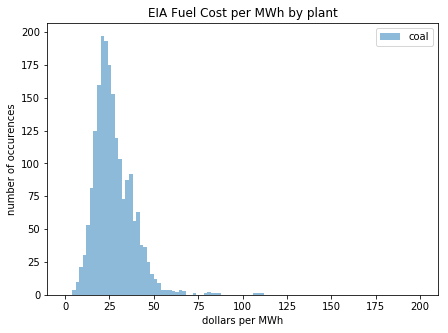

In [41]:
plt.figure(figsize=(7,5))
plt.hist(coal_eia_no_zero.cost_mwh_2,bins=100,range=(0,200),alpha=.5,label='coal')
plt.xlabel('dollars per MWh')
plt.ylabel('number of occurences')
plt.legend()
plt.title('EIA Fuel Cost per MWh by plant')
plt.show()

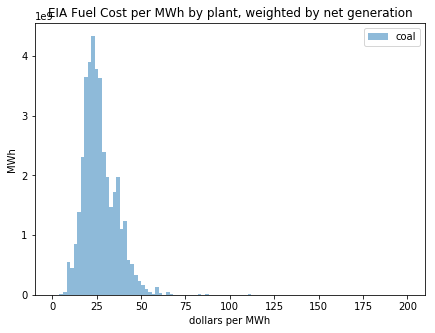

In [42]:
plt.figure(figsize=(7,5))
plt.hist(coal_eia_no_zero.cost_mwh_2,bins=100,weights=coal_eia_no_zero.net_generation_mwh_sum,range=(0,200),alpha=.5,label='coal')
plt.xlabel('dollars per MWh')
plt.ylabel('MWh')
plt.legend()
plt.title('EIA Fuel Cost per MWh by plant, weighted by net generation')
plt.show()

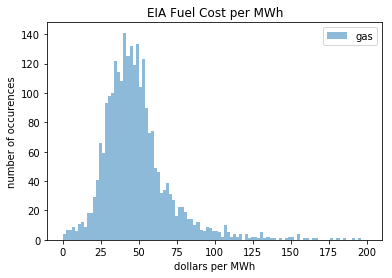

In [43]:
plt.hist(gas_eia_no_zero.cost_mwh_2,bins=100,range=(0,200),alpha=.5,label='gas')
plt.xlabel('dollars per MWh')
plt.ylabel('number of occurences')
plt.legend()
plt.title('EIA Fuel Cost per MWh')
plt.show()

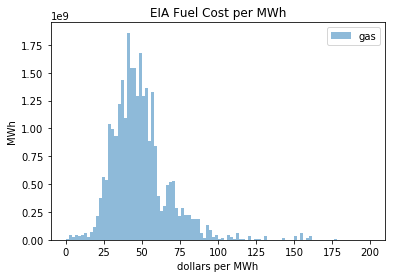

In [44]:
plt.hist(gas_eia_no_zero.cost_mwh_2,weights=gas_eia_no_zero.net_generation_mwh_sum,bins=100,range=(0,200),alpha=.5,label='gas')
plt.xlabel('dollars per MWh')
plt.ylabel('MWh')
plt.legend()
plt.title('EIA Fuel Cost per MWh')
plt.show()

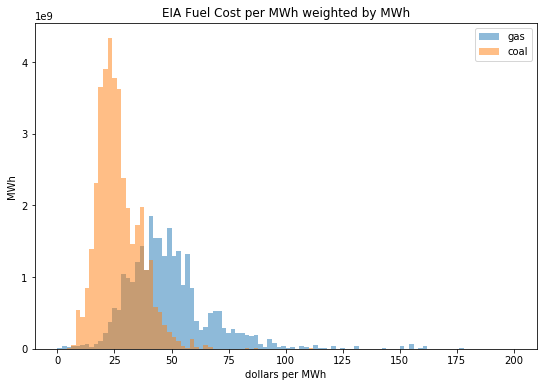

In [45]:
plt.figure(figsize=(9,6))
plt.hist(gas_eia_no_zero.cost_mwh_2,weights=gas_eia_no_zero.net_generation_mwh_sum,bins=100,range=(0,200),alpha=.5,label='gas')
plt.hist(coal_eia_no_zero.cost_mwh_2,bins=100,weights=coal_eia_no_zero.net_generation_mwh_sum,range=(0,200),alpha=.5,label='coal')
plt.xlabel('dollars per MWh')
plt.ylabel('MWh')
plt.legend()
plt.title('EIA Fuel Cost per MWh weighted by MWh')
plt.show()

## FERC Fuel cost per MWh

We'll use the quantile values from the EIA cost per MWh data to clean the F1 fuel data from FERC. There are at least two populations, one where the cost values are in dollars and one where the cost values are in cents.
## Z: Good note on dollars vs. cents -- might want to explicitly tie that to the 0.01 multiplier.  Weird combing in the fixed histogram is probably due to the selection of bin width.  Might want to make that something that's dynamically calculated to be reasonable based on the data, or that you can set when you call showfix().

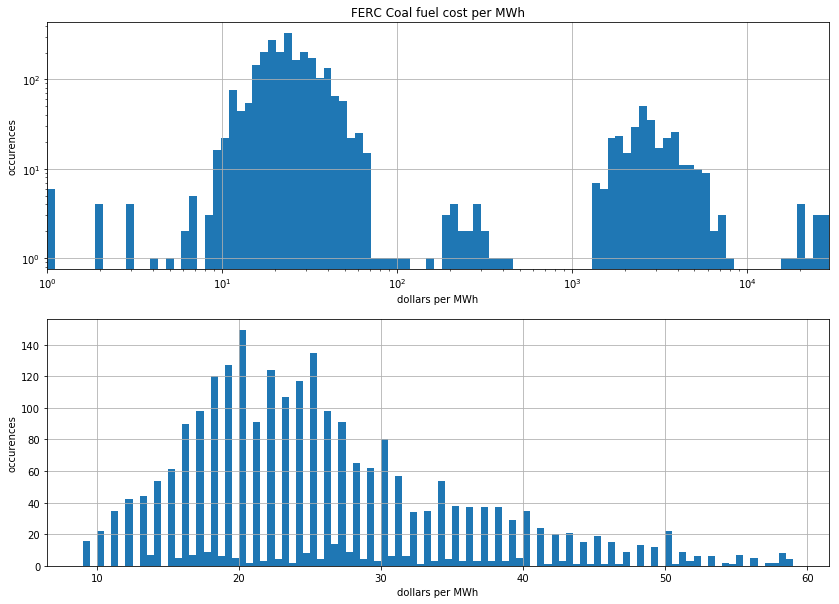

In [46]:
coal_zero_zero = coal[coal.fuel_cost_per_mwh > 0]
to_fix_coal_cost_per_mwh = coal_zero_zero.fuel_cost_per_mwh
fixed_coal_per_mwh = fixit(coal_zero_zero.fuel_cost_per_mwh,9,59,[.01])

fig, fraction_lost = showfix(to_fix_coal_cost_per_mwh,fixed_coal_per_mwh,'FERC Coal fuel cost per MWh','dollars per MWh','occurences')

## Z: The distribution below looks more challenging to clean up. Seems likely that the two humps are actually overlapping which means that any fixed boundary between them will miscategorize some values.

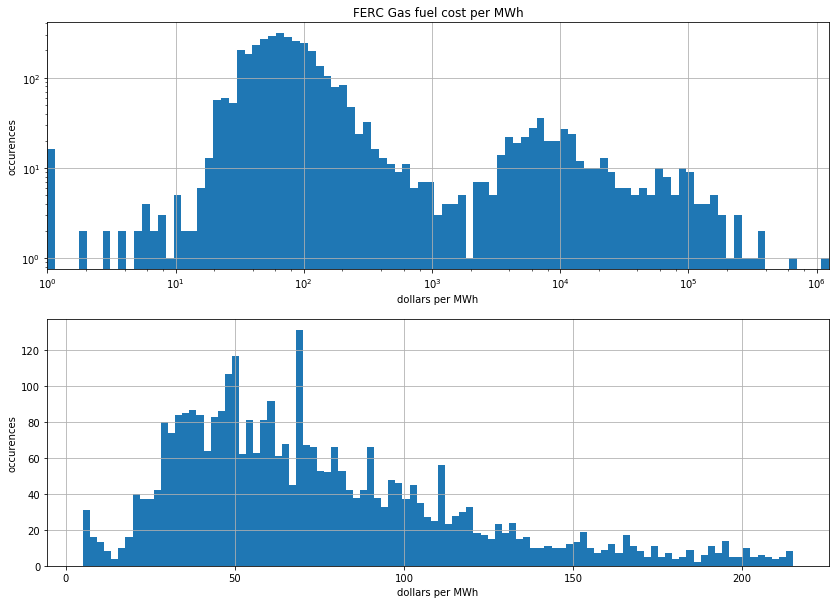

In [47]:
gas_zero_zero = gas[gas.fuel_cost_per_mwh > 0]
to_fix_gas_cost_per_mwh = gas_zero_zero.fuel_cost_per_mwh
fixed_gas_per_mwh = fixit(gas_zero_zero.fuel_cost_per_mwh,5,215,[.01])

fig, fraction_lost = showfix(to_fix_gas_cost_per_mwh,fixed_gas_per_mwh,'FERC Gas fuel cost per MWh','dollars per MWh','occurences')

### Energy contents of coal and gas
- energy content of lignite - 9 - 17 mmbtu per short ton (https://en.wikipedia.org/wiki/Lignite)
- energy content of bituminous - 21 - 30 mmbtu per short ton (https://en.wikipedia.org/wiki/Bituminous_coal)
- energy content of gas - 1.023 mmbtu per mcf (https://www.eia.gov/dnav/ng/ng_cons_heat_a_EPG0_VEUH_btucf_a.htm)

### Pricing data for coal and gas
- energy content of lignite - 9 - 17 mmbtu per short ton (https://en.wikipedia.org/wiki/Lignite)
- energy content of bituminous - 21 - 30 mmbtu per short ton (https://en.wikipedia.org/wiki/Bituminous_coal)
- pricing of gas - https://www.eia.gov/dnav/ng/hist/n3045us3M.htm